#### Загрузка и изучение данных

In [2]:
pip install scikit-learn==1.3.2 -q 

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install shap -q 

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install xgboost lightgbm catboost -q

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install seaborn -q

Note: you may need to restart the kernel to use updated packages.


In [6]:
pip install statsmodels -q

Note: you may need to restart the kernel to use updated packages.


In [60]:
import pandas as pd
import re
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.impute import SimpleImputer
from scipy.stats import shapiro
from pandas.api.types import is_integer_dtype
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold, cross_val_predict
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.feature_selection import SelectKBest, f_classif, mutual_info_classif
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.svm import SVC
from sklearn.metrics import  (
    fbeta_score, f1_score, precision_score, recall_score, roc_auc_score,
    confusion_matrix, make_scorer, average_precision_score
)
from statsmodels.stats.outliers_influence import variance_inflation_factor
import shap
from typing import Optional, List

import warnings
warnings.filterwarnings('ignore')

In [8]:
RANDOM_STATE = 42
TEST_SIZE = 0.25
TARGET_COL = "heart_attack_risk_binary"
sns.set() 

In [9]:
heart_train = pd.read_csv('C:/Users/malen/OneDrive/Desktop/data_since/мастерская 1/data/raw/heart_train.csv', index_col='id')
heart_train.head()

Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
id                                                                              
2664           0  0.359551     0.732143    0.074244       1.0             1.0   
9287           1  0.202247     0.325000    0.047663       1.0             1.0   
5379           2  0.606742     0.860714    0.055912       1.0             0.0   
8222           3  0.730337     0.007143    0.053162       0.0             0.0   
4047           4  0.775281     0.757143    0.021998       0.0             0.0   

      Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
id                                                                    ...   
2664      1.0      1.0                  1.0                 0.535505  ...   
9287      0.0      0.0                  1.0                 0.068690  ...   
5379      1.0      1.0                  1.0                 0.944001  ...   
8222      1.0      0.0                  1.0                 0.697023  ...   
4047      1.0      0.0                  1.0                 0.412878  ...   

      Triglycerides  Physical Activity Days Per Week  Sleep Hours Per Day  \
id                                                                          
2664       0.979221                              3.0             0.333333   
9287       0.515584                              3.0             0.833333   
5379       0.012987                              2.0             1.000000   
8222       0.131169                              0.0             0.333333   
4047       0.070130                              5.0             1.000000   

      Heart Attack Risk (Binary)  Blood sugar     CK-MB  Troponin  Gender  \
id                                                                          
2664                         0.0     0.227018  0.048229  0.036512    Male   
9287                         0.0     0.150198  0.017616  0.000194  Female   
5379                         0.0     0.227018  0.048229  0.036512  Female   
8222                         1.0     0.227018  0.048229  0.036512  Female   
4047                         1.0     0.227018  0.048229  0.036512    Male   

      Systolic blood pressure  Diastolic blood pressure  
id                                                       
2664                 0.212903                  0.709302  
9287                 0.412903                  0.569767  
5379                 0.238710                  0.220930  
8222                 0.348387                  0.267442  
4047                 0.619355                  0.441860  

[5 rows x 27 columns]

In [10]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 27 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       8685 non-null   int64  
 1   Age                              8685 non-null   float64
 2   Cholesterol                      8685 non-null   float64
 3   Heart rate                       8685 non-null   float64
 4   Diabetes                         8442 non-null   float64
 5   Family History                   8442 non-null   float64
 6   Smoking                          8442 non-null   float64
 7   Obesity                          8442 non-null   float64
 8   Alcohol Consumption              8442 non-null   float64
 9   Exercise Hours Per Week          8685 non-null   float64
 10  Diet                             8685 non-null   int64  
 11  Previous Heart Problems          8442 non-null   float64
 12  Medication Use        

heart_train состоит из 8685 записей и 27 столбцов, 243 пропуска в отдельных столбцах. Требуется изменение типа данных object.

In [11]:
heart_test = pd.read_csv('C:/Users/malen/OneDrive/Desktop/data_since/мастерская 1/data/raw/heart_test.csv', index_col='id')
heart_test.head()

Unnamed: 0       Age  Cholesterol  Heart rate  Diabetes  Family History  \
id                                                                              
7746           0  0.494382     0.264286    0.062328       0.0             1.0   
4202           1  0.224719     0.953571    0.082493       1.0             0.0   
6632           2  0.629213     0.092857    0.064161       0.0             1.0   
4639           3  0.460674     0.567857    0.055912       1.0             1.0   
4825           4  0.719101     0.485714    0.022915       1.0             0.0   

      Smoking  Obesity  Alcohol Consumption  Exercise Hours Per Week  ...  \
id                                                                    ...   
7746      1.0      1.0                  1.0                 0.361618  ...   
4202      0.0      1.0                  0.0                 0.996483  ...   
6632      1.0      1.0                  0.0                 0.995561  ...   
4639      1.0      1.0                  1.0                 0.437277  ...   
4825      1.0      0.0                  1.0                 0.514920  ...   

           BMI  Triglycerides  Physical Activity Days Per Week  \
id                                                               
7746  0.283490       0.306494                              1.0   
4202  0.467036       0.087013                              0.0   
6632  0.409366       0.205195                              7.0   
4639  0.910261       0.163636                              0.0   
4825  0.758924       0.580519                              5.0   

      Sleep Hours Per Day  Blood sugar     CK-MB  Troponin  Gender  \
id                                                                   
7746             0.333333     0.227018  0.048229  0.036512    Male   
4202             0.166667     0.227018  0.048229  0.036512  Female   
6632             1.000000     0.102767  0.002666  0.088455    Male   
4639             0.666667     0.203557  0.056390  0.271774  Female   
4825             0.000000     0.227018  0.048229  0.036512    Male   

      Systolic blood pressure  Diastolic blood pressure  
id                                                       
7746                 0.283871                  0.372093  
4202                 0.703226                  0.441860  
6632                 0.458065                  0.779070  
4639                 0.741935                  0.255814  
4825                 0.412903                  0.395349  

[5 rows x 26 columns]

In [12]:
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 7746 to 6521
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Unnamed: 0                       966 non-null    int64  
 1   Age                              966 non-null    float64
 2   Cholesterol                      966 non-null    float64
 3   Heart rate                       966 non-null    float64
 4   Diabetes                         935 non-null    float64
 5   Family History                   935 non-null    float64
 6   Smoking                          935 non-null    float64
 7   Obesity                          935 non-null    float64
 8   Alcohol Consumption              935 non-null    float64
 9   Exercise Hours Per Week          966 non-null    float64
 10  Diet                             966 non-null    int64  
 11  Previous Heart Problems          935 non-null    float64
 12  Medication Use         

heart_test состоит из 8685 записей и 26 столбцов, 31 пропуск в отдельных столбцах. Требуется изменение типа данных object.

In [13]:
heart_train['Unnamed: 0'].value_counts()

Unnamed: 0
0       1
5785    1
5799    1
5798    1
5797    1
       ..
2890    1
2889    1
2888    1
2887    1
8684    1
Name: count, Length: 8685, dtype: int64

In [14]:
heart_test['Unnamed: 0'].value_counts()

Unnamed: 0
0      1
604    1
636    1
637    1
638    1
      ..
326    1
327    1
328    1
329    1
965    1
Name: count, Length: 966, dtype: int64

данный столбец использовался для нумерации строк в таблице, поэтому он нам не нужен.

In [15]:
heart_train = heart_train.drop('Unnamed: 0', axis=1)
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              8685 non-null   float64
 1   Cholesterol                      8685 non-null   float64
 2   Heart rate                       8685 non-null   float64
 3   Diabetes                         8442 non-null   float64
 4   Family History                   8442 non-null   float64
 5   Smoking                          8442 non-null   float64
 6   Obesity                          8442 non-null   float64
 7   Alcohol Consumption              8442 non-null   float64
 8   Exercise Hours Per Week          8685 non-null   float64
 9   Diet                             8685 non-null   int64  
 10  Previous Heart Problems          8442 non-null   float64
 11  Medication Use                   8442 non-null   float64
 12  Stress Level          

In [16]:
heart_test = heart_test.drop('Unnamed: 0', axis=1)
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 7746 to 6521
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   Age                              966 non-null    float64
 1   Cholesterol                      966 non-null    float64
 2   Heart rate                       966 non-null    float64
 3   Diabetes                         935 non-null    float64
 4   Family History                   935 non-null    float64
 5   Smoking                          935 non-null    float64
 6   Obesity                          935 non-null    float64
 7   Alcohol Consumption              935 non-null    float64
 8   Exercise Hours Per Week          966 non-null    float64
 9   Diet                             966 non-null    int64  
 10  Previous Heart Problems          935 non-null    float64
 11  Medication Use                   935 non-null    float64
 12  Stress Level           

#### Предобработка данных

Выполним предобработку данных. Изменим названия столбцов, типы данных, где это необходимо. Проведем проверку на явные и неявные дубликаты в данных.

##### Изменение наименования столбцов

Приведем наименования столбцов к змеиному регистру

In [17]:
def to_snake_case(name):
    name = name.strip()
    name = re.sub(r'[\s\-]+', '_', name)               # пробелы и дефисы → _
    name = re.sub(r'([a-z0-9])([A-Z])', r'\1_\2', name) # camelCase → camel_case
    name = re.sub(r'[^\w_]', '', name)                  # убрать лишние символы
    return name.lower()

heart_train.columns = [to_snake_case(c) for c in heart_train.columns]
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   int64  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 12  stress_level          

In [18]:
heart_test.columns = [to_snake_case(c) for c in heart_test.columns]
heart_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 966 entries, 7746 to 6521
Data columns (total 25 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              966 non-null    float64
 1   cholesterol                      966 non-null    float64
 2   heart_rate                       966 non-null    float64
 3   diabetes                         935 non-null    float64
 4   family_history                   935 non-null    float64
 5   smoking                          935 non-null    float64
 6   obesity                          935 non-null    float64
 7   alcohol_consumption              935 non-null    float64
 8   exercise_hours_per_week          966 non-null    float64
 9   diet                             966 non-null    int64  
 10  previous_heart_problems          935 non-null    float64
 11  medication_use                   935 non-null    float64
 12  stress_level           

##### Обработка пропусков

In [19]:
heart_train[heart_train['stress_level'].isna()]

age  cholesterol  heart_rate  diabetes  family_history  smoking  \
id                                                                           
9528  0.449438      0.49978    0.063245       NaN             NaN      NaN   
9640  0.370787      0.49978    0.066911       NaN             NaN      NaN   
9515  0.629213      0.49978    0.073327       NaN             NaN      NaN   
9491  0.516854      0.49978    0.045830       NaN             NaN      NaN   
9448  0.269663      0.49978    0.035747       NaN             NaN      NaN   
...        ...          ...         ...       ...             ...      ...   
9455  0.719101      0.49978    0.049496       NaN             NaN      NaN   
9506  0.651685      0.49978    0.036664       NaN             NaN      NaN   
9474  0.651685      0.49978    0.054079       NaN             NaN      NaN   
9467  0.606742      0.49978    0.059578       NaN             NaN      NaN   
9555  0.629213      0.49978    0.057745       NaN             NaN      NaN   

      obesity  alcohol_consumption  exercise_hours_per_week  diet  ...  \
id                                                                 ...   
9528      NaN                  NaN                  0.50211     3  ...   
9640      NaN                  NaN                  0.50211     3  ...   
9515      NaN                  NaN                  0.50211     3  ...   
9491      NaN                  NaN                  0.50211     3  ...   
9448      NaN                  NaN                  0.50211     3  ...   
...       ...                  ...                      ...   ...  ...   
9455      NaN                  NaN                  0.50211     3  ...   
9506      NaN                  NaN                  0.50211     3  ...   
9474      NaN                  NaN                  0.50211     3  ...   
9467      NaN                  NaN                  0.50211     3  ...   
9555      NaN                  NaN                  0.50211     3  ...   

      triglycerides  physical_activity_days_per_week  sleep_hours_per_day  \
id                                                                          
9528       0.503603                              NaN             0.504621   
9640       0.503603                              NaN             0.504621   
9515       0.503603                              NaN             0.504621   
9491       0.503603                              NaN             0.504621   
9448       0.503603                              NaN             0.504621   
...             ...                              ...                  ...   
9455       0.503603                              NaN             0.504621   
9506       0.503603                              NaN             0.504621   
9474       0.503603                              NaN             0.504621   
9467       0.503603                              NaN             0.504621   
9555       0.503603                              NaN             0.504621   

      heart_attack_risk_binary  blood_sugar     ck_mb  troponin  gender  \
id                                                                        
9528                       0.0     0.233202  0.026692  0.000777     1.0   
9640                       0.0     0.154150  0.004702  0.042043     1.0   
9515                       0.0     0.256917  0.012310  0.000777     0.0   
9491                       0.0     0.559289  0.006704  0.000291     0.0   
9448                       0.0     0.112648  0.051218  0.000485     0.0   
...                        ...          ...       ...       ...     ...   
9455                       0.0     0.138340  0.004034  0.003204     1.0   
9506                       0.0     0.239130  0.055790  0.060783     1.0   
9474                       0.0     0.276680  0.008673  0.150403     1.0   
9467                       0.0     0.156126  0.057692  0.000583     0.0   
9555                       0.0     0.148221  0.004001  0.067968     1.0   

      systolic_blood_pressure  diastolic_blood_pressure

В обучающем наборе данных пропуски встречаются только в 9 конкретных признаках:
diabetes, family_history, smoking, obesity, alcohol_consumption,
physical_activity_days_per_week, previous_heart_problems, medication_use, stress_level.

Все они связаны с образом жизни и историей болезни пациента.
Количество пропусков одинаковое во всех этих колонках — 243 записи (≈ 2,8% датасета). Это значит, что пропуски не случайны, а возникают «пакетом» для целых строк, что, вероятно, связано с особенностями сбора данных (например, неполные анкеты или пациенты, которым не задавали эти вопросы).

Потеря 2,8% строк снизит размер обучающей выборки и может убрать целую подгруппу пациентов, что приведёт к смещению распределения признаков.

В тестовых данных возможны такие же паттерны пропусков, и если мы их выбросим из train, модель не научится корректно обрабатывать такие случаи.

Пропуски содержат потенциально полезную информацию — сам факт, что данные не заполнены, может коррелировать с вероятностью сердечного приступа (например, пациенты с неполной медицинской историей).

Стратегия обработки NaN:
- Сохранить все строки, включая те, где есть пропуски.
- Добавить индикаторные признаки __was_missing для каждого из 9 признаков с пропусками — 1, если значение отсутствует, и 0, если присутствует. Это позволит модели учитывать сам факт пропуска как сигнал.
- Импутировать пропуски. Для бинарных признаков (0/1) — мода по обучающим данным. Для порядковых признаков (stress_level, physical_activity_days_per_week) — медиана. Для остальных числовых признаков — медиана.

Такой подход минимизирует потерю информации, сохраняет распределения признаков, даёт модели возможность использовать признак «пропуск» как фактор прогноза, и при этом обеспечивает готовность данных для алгоритмов, которые не работают с NaN напрямую.

##### Обработка дубликатов

Перед построением модели прогнозирования риска сердечного приступа необходимо провести предварительную проверку качества исходных данных. Цель — выявить и устранить записи, которые могут исказить обучение модели: полные дубликаты строк, дубликаты с противоречивыми значениями целевого признака, а также неявные повторы. Это позволяет снизить риск переобучения, исключить влияние повторяющихся пациентов и повысить обобщающую способность модели.

Проверка на дубликаты выполняется в несколько этапов:
1. Полные дубликаты
- Ищем строки, полностью совпадающие по всем признакам (включая целевой признак).
- Если такие строки есть, оставляем только первую, остальные удаляем.
- Это исключает ситуации, когда один и тот же пациент учитывается несколько раз без изменений данных.

2. Дубликаты по признакам с разными значениями целевого признака (конфликтные записи)
- Определяем группы записей, полностью совпадающих по всем признакам, кроме целевого (heart_attack_risk_binary).
- Если внутри группы встречаются разные значения целевого признака, удаляем все такие записи.
- Это предотвращает попадание в обучающую выборку противоречивой информации, которая мешает алгоритму обучаться.

3. Дубликаты по признакам с одинаковым целевым признаком (неявные дубликаты)
- Если записи совпадают по всем признакам и целевому признаку, но различаются по индексу (ID), оставляем только первую.
- Это снижает искусственное увеличение веса отдельных примеров в обучении.

In [20]:
def drop_duplicates_and_conflicts(df: pd.DataFrame, target_col: str) -> pd.DataFrame:
    """
    Удаляет полные и конфликтные дубликаты и печатает статистику.
    """
    df = df.copy()

    # 1) Полные дубликаты
    full_dupes = df.duplicated(keep="first")
    n_full_dupes = full_dupes.sum()
    df = df[~full_dupes]

    # 2) Конфликтные дубликаты (одинаковые фичи, разный таргет)
    feature_cols = [c for c in df.columns if c != target_col]
    grp = df.groupby(feature_cols, dropna=False)[target_col].nunique()
    conflict_keys = grp[grp > 1].index
    n_conflict_groups = len(conflict_keys)

    if n_conflict_groups > 0:
        conflict_df = pd.DataFrame(list(conflict_keys), columns=feature_cols)
        df = df.merge(conflict_df.assign(__conflict__=1), how="left", on=feature_cols)
        df = df[df["__conflict__"].isna()].drop(columns="__conflict__")

    # 3) Неявные дубликаты (одинаковые фичи + одинаковый таргет)
    feature_cols = [c for c in df.columns if c != target_col]
    same_dupes = df.duplicated(subset=feature_cols + [target_col], keep="first")
    n_same_dupes = same_dupes.sum()
    df = df[~same_dupes]

    # --- Вывод результатов ---
    print("Результат проверки для текущих данных")
    print(f"Полные дубликаты: {n_full_dupes} записей.")
    print(f"Дубликаты по признакам с разными целевыми значениями: {n_conflict_groups} групп.")
    print(f"Неявные дубликаты (одинаковые признаки + одинаковый целевой): {n_same_dupes} записей.")

    return df

In [21]:
heart_train = drop_duplicates_and_conflicts(heart_train, 'heart_attack_risk_binary')

Результат проверки для текущих данных
Полные дубликаты: 0 записей.
Дубликаты по признакам с разными целевыми значениями: 0 групп.
Неявные дубликаты (одинаковые признаки + одинаковый целевой): 0 записей.


Таким образом, в данных нет явных или скрытых дубликатов, которые требовали бы удаления, однако проверка включена в предобработку для предотвращения подобных проблем при поступлении новых данных.

##### Нормализация столбца gender

In [22]:
heart_train['gender'].value_counts()

gender
Male      5882
Female    2560
1.0        156
0.0         87
Name: count, dtype: int64

In [23]:
heart_test['gender'].value_counts()

gender
Male      650
Female    285
1.0        22
0.0         9
Name: count, dtype: int64

В исходных данных признак gender представлен в смешанном формате: часть записей — строковые значения (Male/Female), часть — числовые (0, 1, 0.0, 1.0). Такой разнородный тип данных может вызвать ошибки или некорректное поведение при автоматической обработке в пайплайне.

Таким образом, принято решение закодировать gender вручную в числовой бинарный формат (1 — мужчина, 0 — женщина) до подачи данных в модель.

In [24]:
def normalize_gender(series: pd.Series) -> pd.Series:
    """
    male/female, '1'/'0', '1.0'/'0.0' -> {1.0, 0.0}, NaN сохраняем
    """
    s = series.astype(str).str.strip().str.lower()
    s = (s.replace({"male":"1","female":"0"})
           .str.replace(".0","", regex=False)
           .replace({"nan": np.nan}))
    return pd.to_numeric(s, errors="coerce")

In [25]:
if "gender" in heart_train.columns:
    heart_train["gender"] = normalize_gender(heart_train["gender"])
if "gender" in heart_test.columns:
    heart_test["gender"] = normalize_gender(heart_test["gender"])

In [26]:
heart_train['gender'].value_counts()

gender
1    6038
0    2647
Name: count, dtype: int64

In [27]:
heart_test['gender'].value_counts()

gender
1    672
0    294
Name: count, dtype: int64

Таким образом, gender был преобразован в единый числовой флаг, что делает обработку данных более надёжной и предсказуемой для всех типов моделей, включая алгоритмы деревьев и линейные классификаторы.

##### Изменение типа данных

Для бинарных, категориальных и порядковых признаков надёжнее переводить значения в int перед кодированием — это исключает неоднозначную интерпретацию и проблемы с обработкой, а так же уберет визуальный шум при построении графиков.

In [28]:
int_features = [
    'diabetes',
    'family_history',
    'smoking',
    'obesity',
    'alcohol_consumption',
    'previous_heart_problems',
    'medication_use',
    'gender',
    
    # Порядковые признаки
    'diet',
    'stress_level',
    'physical_activity_days_per_week'
]

# Приведение к int
for col in int_features:
    heart_train[col] = heart_train[col].dropna().astype(int)
    heart_test[col] = heart_test[col].dropna().astype(int)

In [29]:
heart_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 8685 entries, 2664 to 7270
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              8685 non-null   float64
 1   cholesterol                      8685 non-null   float64
 2   heart_rate                       8685 non-null   float64
 3   diabetes                         8442 non-null   float64
 4   family_history                   8442 non-null   float64
 5   smoking                          8442 non-null   float64
 6   obesity                          8442 non-null   float64
 7   alcohol_consumption              8442 non-null   float64
 8   exercise_hours_per_week          8685 non-null   float64
 9   diet                             8685 non-null   int32  
 10  previous_heart_problems          8442 non-null   float64
 11  medication_use                   8442 non-null   float64
 12  stress_level          

#### Исследовательский анализ данных

#####  Статистический анализ числовых признаков

In [30]:
heart_train.describe()

age  cholesterol   heart_rate     diabetes  family_history  \
count  8685.000000  8685.000000  8685.000000  8442.000000     8442.000000   
mean      0.449958     0.501070     0.050658     0.652097        0.489576   
std       0.231174     0.284716     0.023453     0.476333        0.499921   
min       0.000000     0.000000     0.000000     0.000000        0.000000   
25%       0.258427     0.267857     0.034830     0.000000        0.000000   
50%       0.460674     0.499780     0.050412     1.000000        0.000000   
75%       0.640449     0.746429     0.065995     1.000000        1.000000   
max       1.000000     1.000000     1.000000     1.000000        1.000000   

           smoking      obesity  alcohol_consumption  exercise_hours_per_week  \
count  8442.000000  8442.000000          8442.000000              8685.000000   
mean      0.902867     0.498342             0.601990                 0.503378   
std       0.296157     0.500027             0.489517                 0.284810   
min       0.000000     0.000000             0.000000                 0.000000   
25%       1.000000     0.000000             0.000000                 0.263286   
50%       1.000000     0.000000             1.000000                 0.502110   
75%       1.000000     1.000000             1.000000                 0.748709   
max       1.000000     1.000000             1.000000                 1.000000   

              diet  ...  triglycerides  physical_activity_days_per_week  \
count  8685.000000  ...    8685.000000                      8442.000000   
mean      1.057455  ...       0.505484                         3.508292   
std       0.866645  ...       0.286320                         2.281772   
min       0.000000  ...       0.000000                         0.000000   
25%       0.000000  ...       0.263636                         2.000000   
50%       1.000000  ...       0.503603                         3.000000   
75%       2.000000  ...       0.750649                         6.000000   
max       3.000000  ...       1.000000                         7.000000   

       sleep_hours_per_day  heart_attack_risk_binary  blood_sugar  \
count          8685.000000               8685.000000  8685.000000   
mean              0.503737                  0.346920     0.227339   
std               0.328061                  0.476017     0.076635   
min               0.000000                  0.000000     0.000000   
25%               0.166667                  0.000000     0.227018   
50%               0.500000                  0.000000     0.227018   
75%               0.833333                  1.000000     0.227018   
max               1.000000                  1.000000     1.000000   

             ck_mb     troponin       gender  systolic_blood_pressure  \
count  8685.000000  8685.000000  8685.000000              8685.000000   
mean      0.048159     0.036689     0.695222                 0.450295   
std       0.075531     0.060157     0.460340                 0.170184   
min       0.000000     0.000000     0.000000                 0.000000   
25%       0.048229     0.036512     0.000000                 0.303226   
50%       0.048229     0.036512     1.000000                 0.445161   
75%       0.048229     0.036512     1.000000                 0.600000   
max       1.000000     1.000000     1.000000                 1.000000   

       diastolic_blood_pressure  
count               8685.000000  
mean                   0.497634  
std                    0.171830  
min                    0.000000  
25%                    0.348837  
50%                    0.500000  
75%                    0.651163  
max                    1.000000  

[8 rows x 26 columns]

Большинство признаков — числовые (float), но значения в диапазоне [0,1] встречаются очень часто, что говорит о масштабировании (min-max normalization) или кодировании как доли.
Есть признаки, где значения — целые числа в небольших диапазонах.

1. Признаки, вероятно, масштабированные в [0,1]
- Почти все «медицинские» метрики имеют: min = 0, max = 1, Средние ≈ 0.45–0.50, std ~0.28
- Это сильно похоже на min-max scaling до диапазона [0,1]. Примеры: age, cholesterol, triglycerides, blood_sugar, ck_mb, troponin.

2. Бинарные признаки (0/1)
- diabetes, family_history, smoking, obesity, alcohol_consumption, previous_heart_problems, medication_use, gender
- Минимум = 0, максимум = 1, среднее в диапазоне 0.48–0.90 (разный баланс классов).
- Вероятно, изначально были категориальные ответы («Да/Нет») → закодированы в 0/1.

3. Порядковые признаки
- physical_activity_days_per_week: min=0, max=7, медиана=3 → это кол-во активных дней в неделю.
- stress_level: min=1, max=10, равномерное распределение по шкале.

4. Целевой признак
- heart_attack_risk_binary: баланс сильно смещён — среднее 0.3469 → ~34,7% положительных случаев.
- Это несбалансированный датасет → при моделировании придётся учитывать (class_weight, oversampling/undersampling, metrics focus).

Выводы:
- Бинарные признаки — не масштабировать, просто импутировать модой + оставить индикаторы пропусков.
- Порядковые признаки — импутировать медианой.
- Масштабированные признаки — оставить как есть, чтобы не «перемасштабировать».
- Несбалансированность таргета — использовать метрики чувствительные к дисбалансу (ROC-AUC, PR-AUC, Recall) и балансировку классов в моделях.

In [31]:
heart_test.describe()

age  cholesterol  heart_rate    diabetes  family_history  \
count  966.000000   966.000000  966.000000  935.000000      935.000000   
mean     0.452916     0.488181    0.051644    0.656684        0.481283   
std      0.231068     0.282039    0.035502    0.475070        0.499917   
min      0.044944     0.000000    0.000000    0.000000        0.000000   
25%      0.247191     0.243750    0.036664    0.000000        0.000000   
50%      0.460674     0.499780    0.050412    1.000000        0.000000   
75%      0.640449     0.710714    0.065995    1.000000        1.000000   
max      0.853933     0.996429    1.000000    1.000000        1.000000   

          smoking     obesity  alcohol_consumption  exercise_hours_per_week  \
count  935.000000  935.000000           935.000000               966.000000   
mean     0.898396    0.516578             0.583957                 0.490706   
std      0.302289    0.499993             0.493165                 0.284902   
min      0.000000    0.000000             0.000000                 0.000336   
25%      1.000000    0.000000             0.000000                 0.243431   
50%      1.000000    1.000000             1.000000                 0.502110   
75%      1.000000    1.000000             1.000000                 0.734425   
max      1.000000    1.000000             1.000000                 0.998938   

             diet  ...         bmi  triglycerides  \
count  966.000000  ...  966.000000     966.000000   
mean     1.053830  ...    0.476796       0.486688   
std      0.884642  ...    0.291987       0.284534   
min      0.000000  ...    0.002598       0.000000   
25%      0.000000  ...    0.217527       0.249675   
50%      1.000000  ...    0.471185       0.488961   
75%      2.000000  ...    0.720503       0.718182   
max      3.000000  ...    0.999496       0.998701   

       physical_activity_days_per_week  sleep_hours_per_day  blood_sugar  \
count                       935.000000           966.000000   966.000000   
mean                          3.443850             0.512571     0.224127   
std                           2.302778             0.322292     0.065270   
min                           0.000000             0.000000     0.029644   
25%                           1.000000             0.166667     0.227018   
50%                           3.000000             0.500000     0.227018   
75%                           5.000000             0.833333     0.227018   
max                           7.000000             1.000000     0.750988   

            ck_mb    troponin      gender  systolic_blood_pressure  \
count  966.000000  966.000000  966.000000               966.000000   
mean     0.048855    0.034926    0.695652                 0.447172   
std      0.079742    0.053855    0.460369                 0.171837   
min      0.000000    0.000194    0.000000                 0.012903   
25%      0.048229    0.036512    0.000000                 0.296774   
50%      0.048229    0.036512    1.000000                 0.445161   
75%      0.048229    0.036512    1.000000                 0.600000   
max      1.000000    0.970871    1.000000                 0.741935   

       diastolic_blood_pressure  
count                966.000000  
mean                   0.496822  
std                    0.173935  
min                    0.116279  
25%                    0.348837  
50%                    0.488372  
75%                    0.639535  
max                    0.790698  

[8 rows x 25 columns]

В тестовом наборе картинка почти та же, что и в train, что хорошо для обучения.

Перед началом анализа признаков мы отдельно рассматриваем распределение целевого признака heart_attack_risk_binary. Этот шаг необходим, чтобы оценить баланс классов в выборке и понять, требуется ли в дальнейшем применение методов коррекции дисбаланса (например, использование параметра class_weight, oversampling или undersampling).

В нашем случае целевой признак бинарный:

0 — отсутствие риска сердечного приступа,

1 — наличие риска.

Анализ распределения позволит заранее определить долю каждого класса и выбрать подходящие метрики для оценки модели. При сильной несбалансированности классов особое внимание будет уделено метрикам, чувствительным к дисбалансу, таким как ROC-AUC, PR-AUC и Recall.

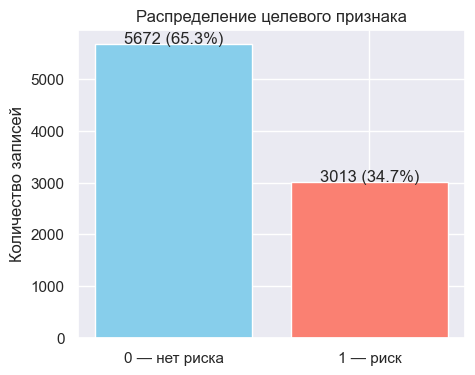

heart_attack_risk_binary
0.0    5672
1.0    3013
Name: count, dtype: int64
heart_attack_risk_binary
0.0    65.31
1.0    34.69
Name: count, dtype: float64


In [32]:
# Распределение целевого признака
target_counts = heart_train["heart_attack_risk_binary"].value_counts().sort_index()
target_perc = target_counts / target_counts.sum() * 100

plt.figure(figsize=(5,4))
plt.bar(target_counts.index.astype(str), target_counts.values, color=["skyblue","salmon"])
plt.xticks([0,1], ["0 — нет риска", "1 — риск"])
plt.ylabel("Количество записей")
plt.title("Распределение целевого признака")

# Печать чисел и процентов
for idx, val in enumerate(target_counts.values):
    plt.text(idx, val + 10, f"{val} ({target_perc.iloc[idx]:.1f}%)", ha="center")

plt.show()

print(target_counts)
print(target_perc.round(2))

После изучения распределения целевого признака переходим к анализу всех входных признаков в обучающем наборе данных. Цель этого этапа — выявить особенности распределений, определить тип каждого признака (бинарный, дискретный, порядковый или непрерывный), а также зафиксировать потенциальные аномалии или выбросы.

Для каждого числового признака строятся:

Диаграмма распределения (гистограмма для непрерывных признаков или столбчатая диаграмма для дискретных/бинарных);

Боксплот для визуального обнаружения выбросов и оценки диапазона значений.

Этот анализ помогает:

Определить признаки, требующие особой предобработки (масштабирование, кодирование, удаление выбросов);

Проверить согласованность данных в train и test;

Найти признаки, которые уже нормированы или закодированы, чтобы избежать лишней обработки в пайплайне.

Особое внимание уделяется бинарным и порядковым признакам, так как для них используются отдельные стратегии импутации и обработки.

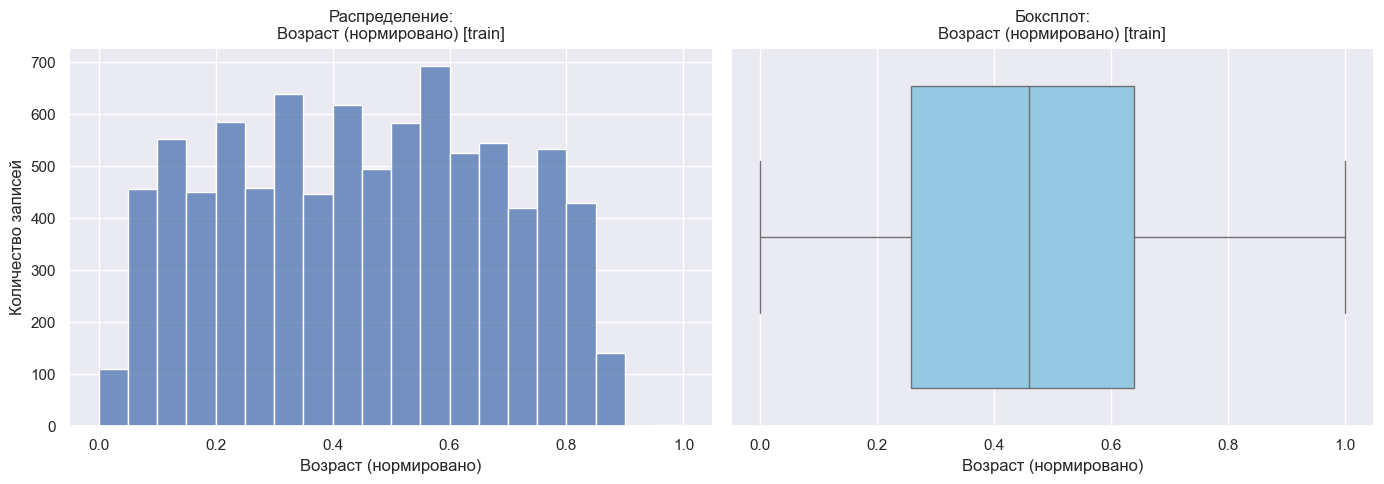

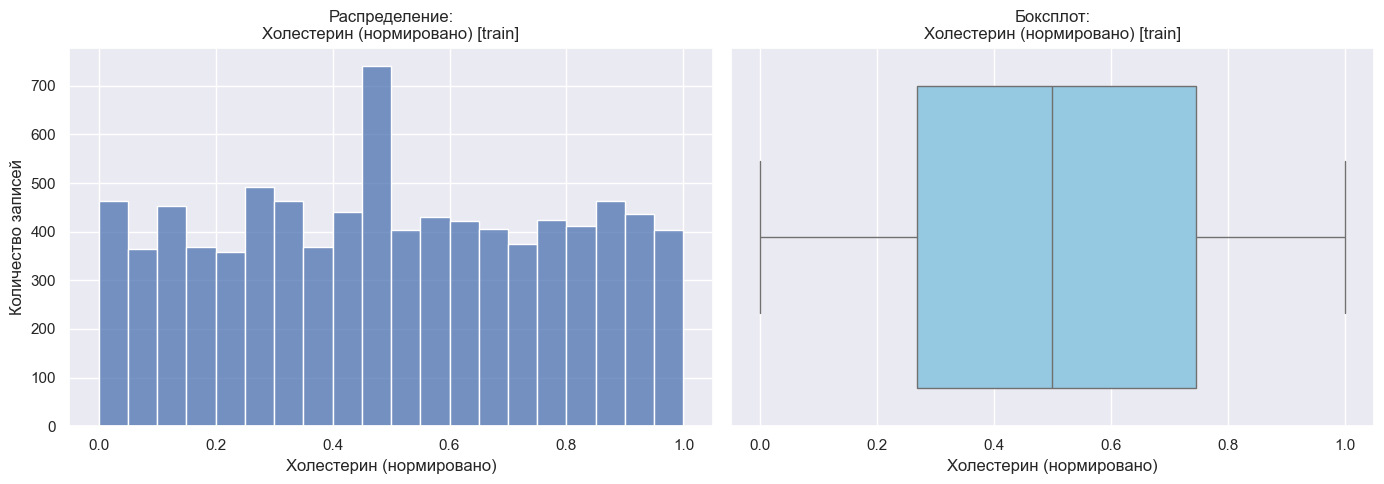

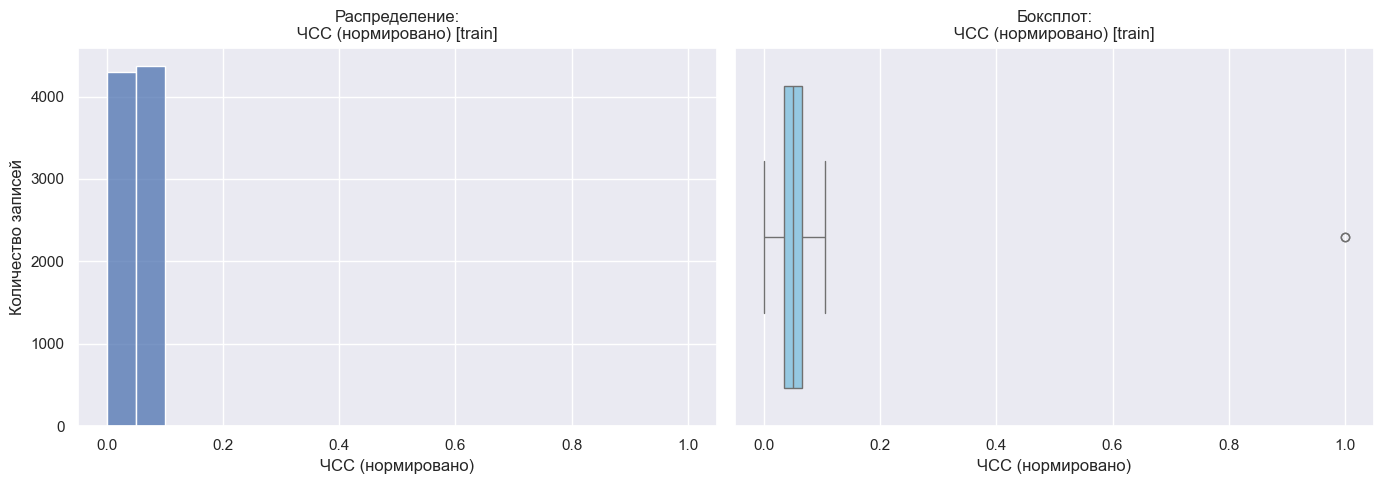

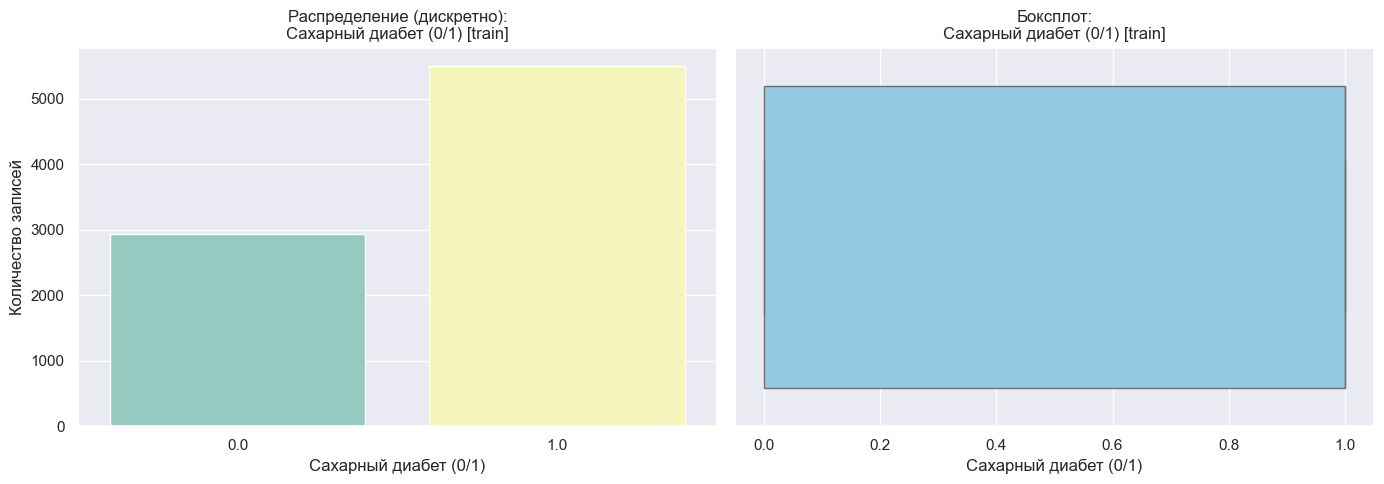

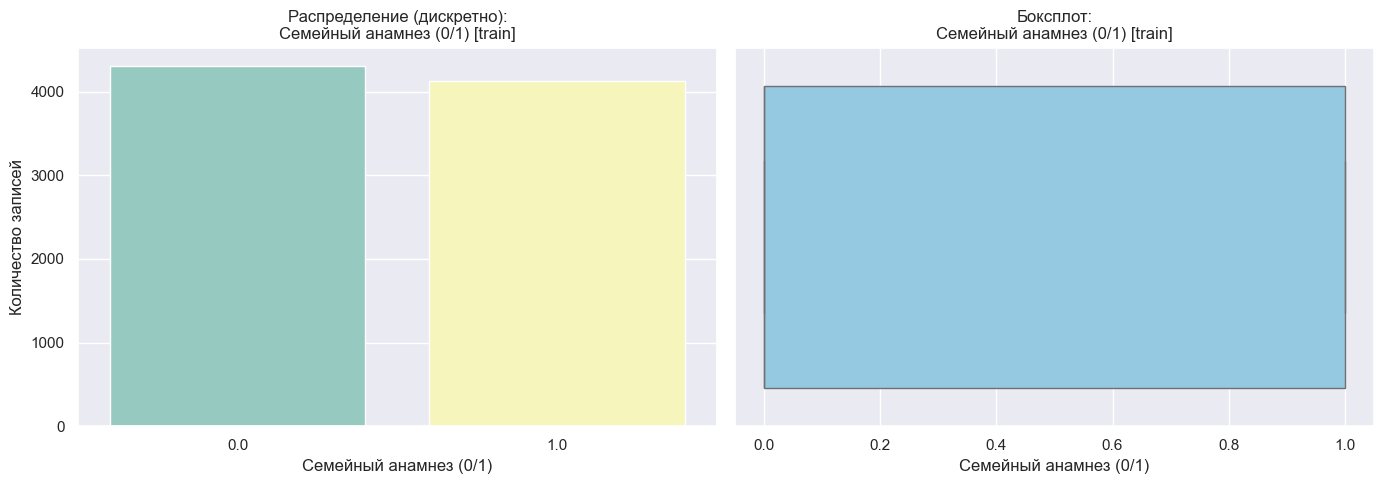

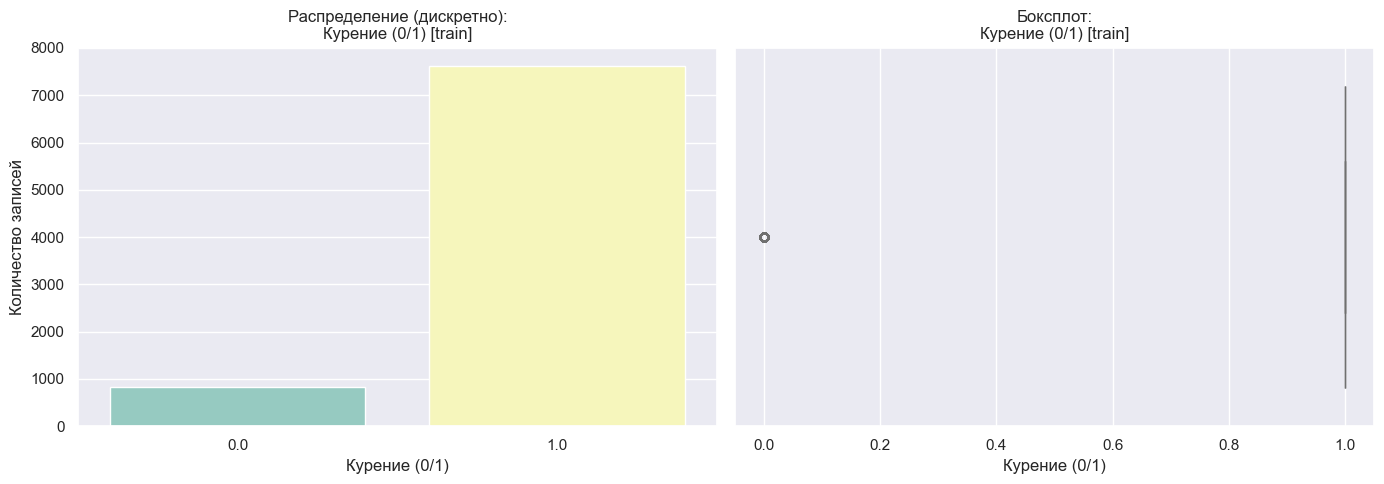

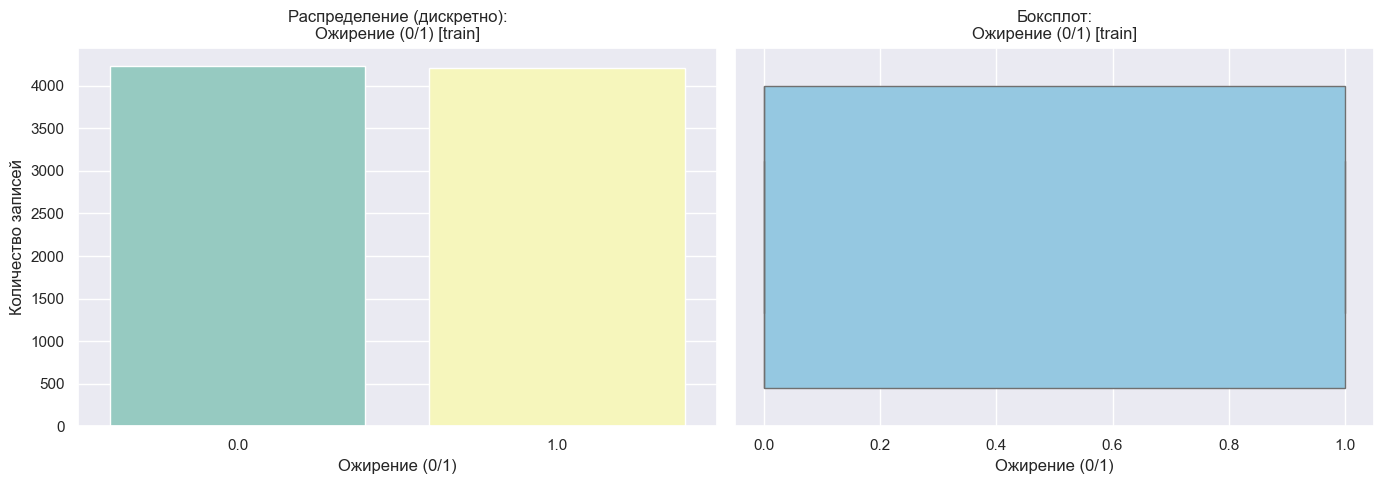

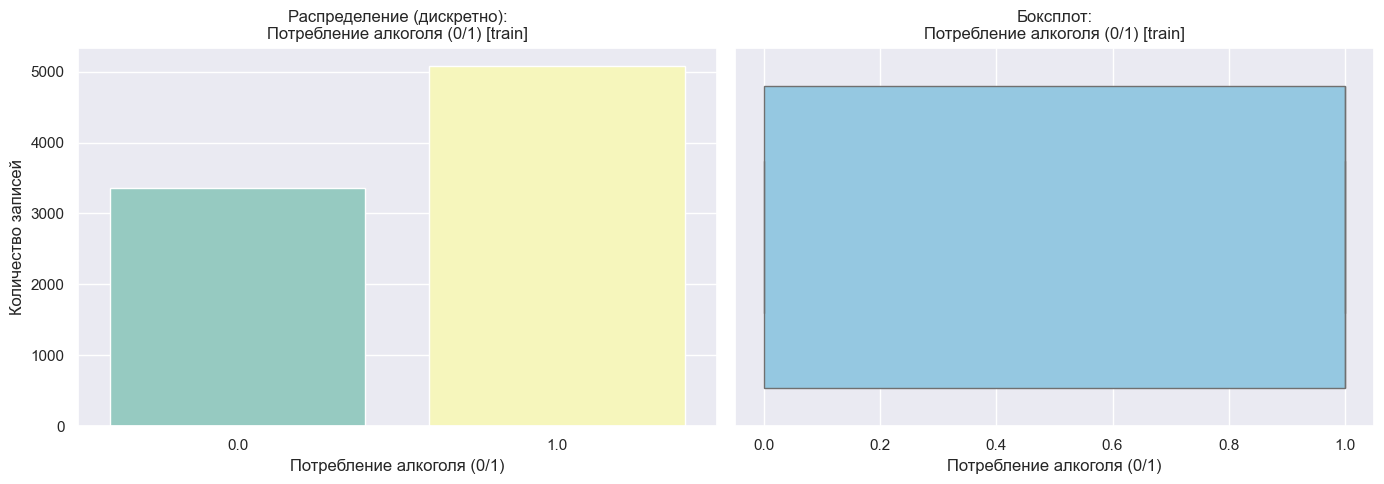

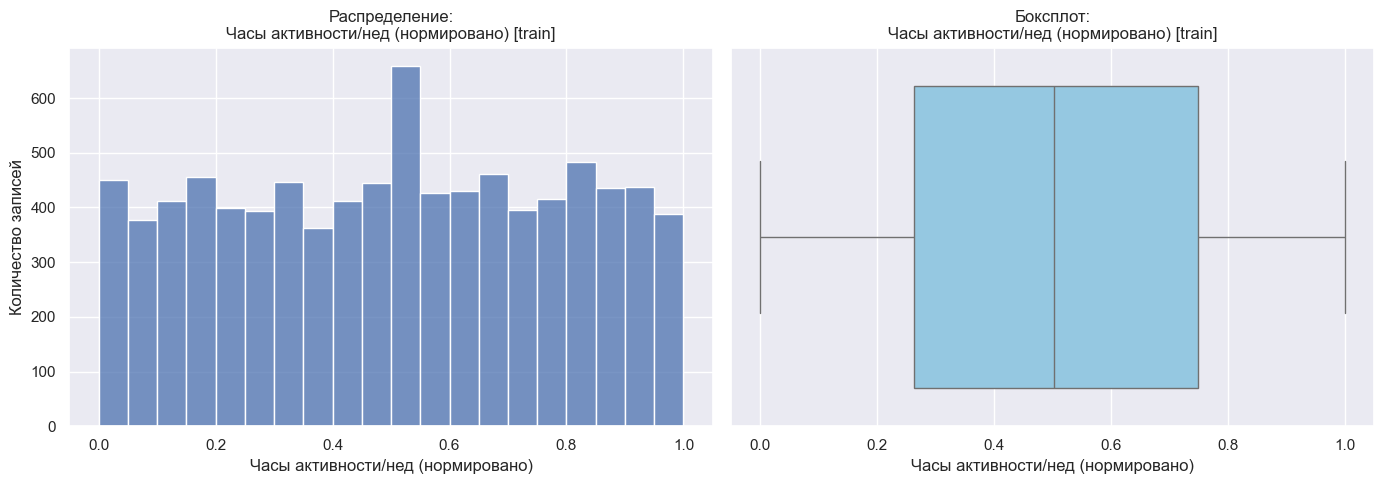

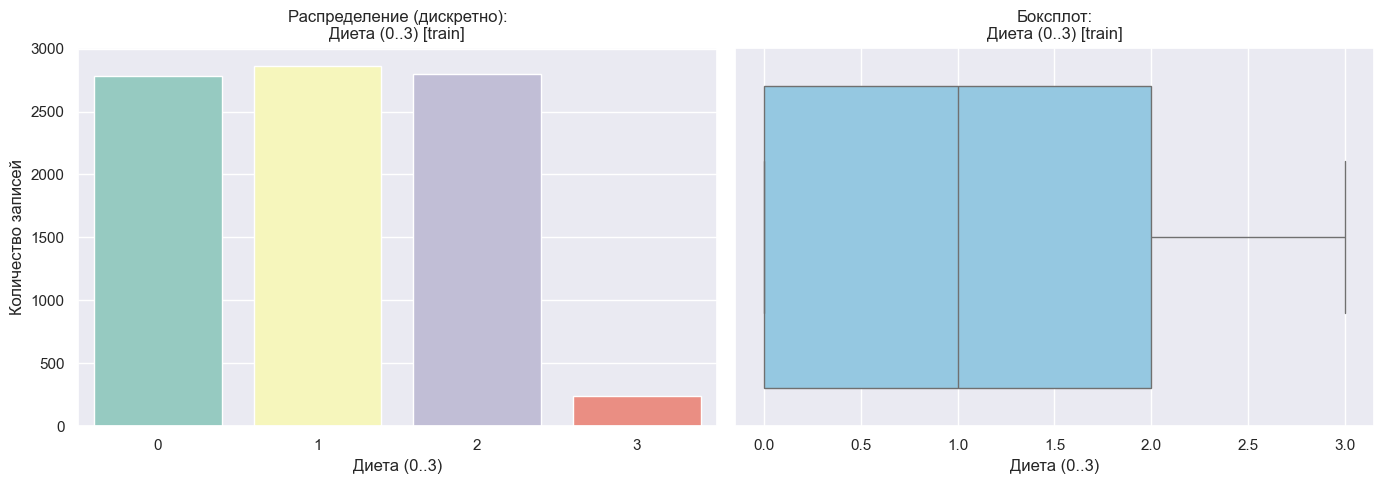

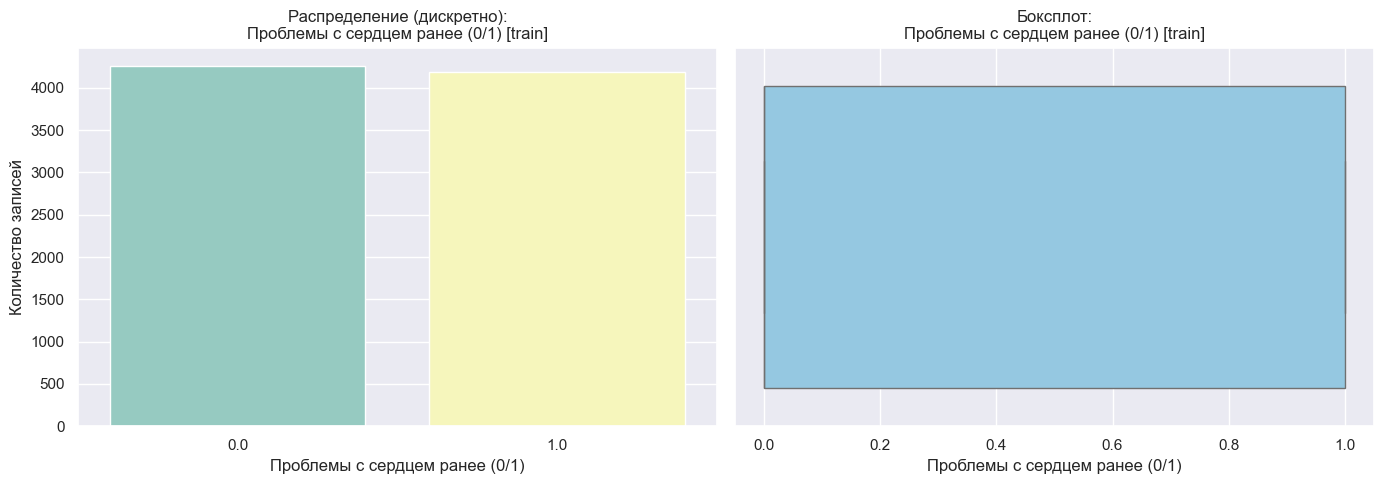

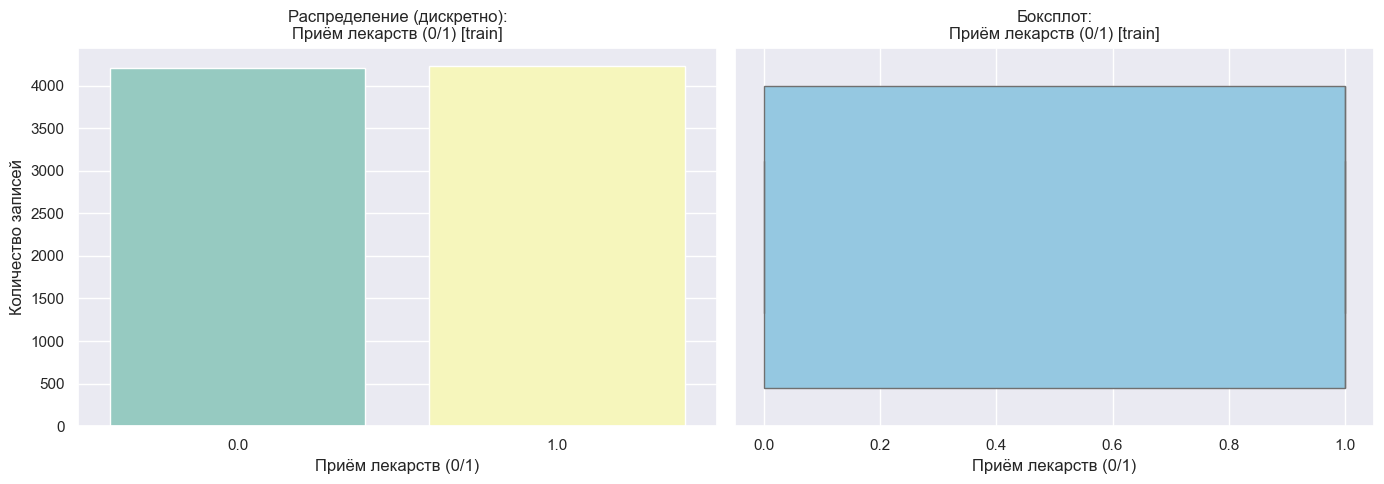

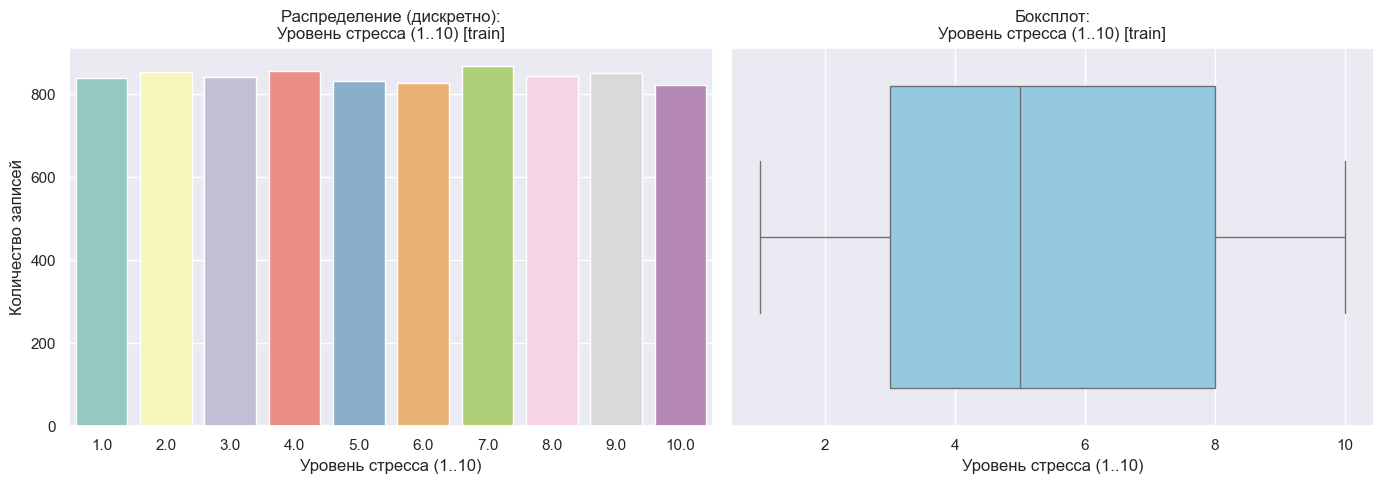

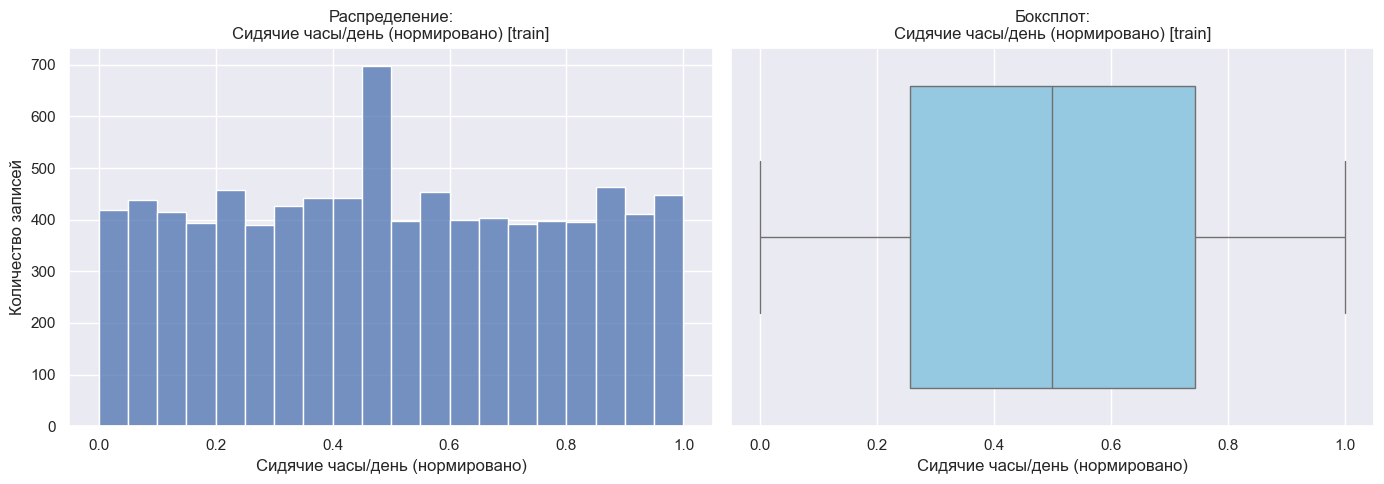

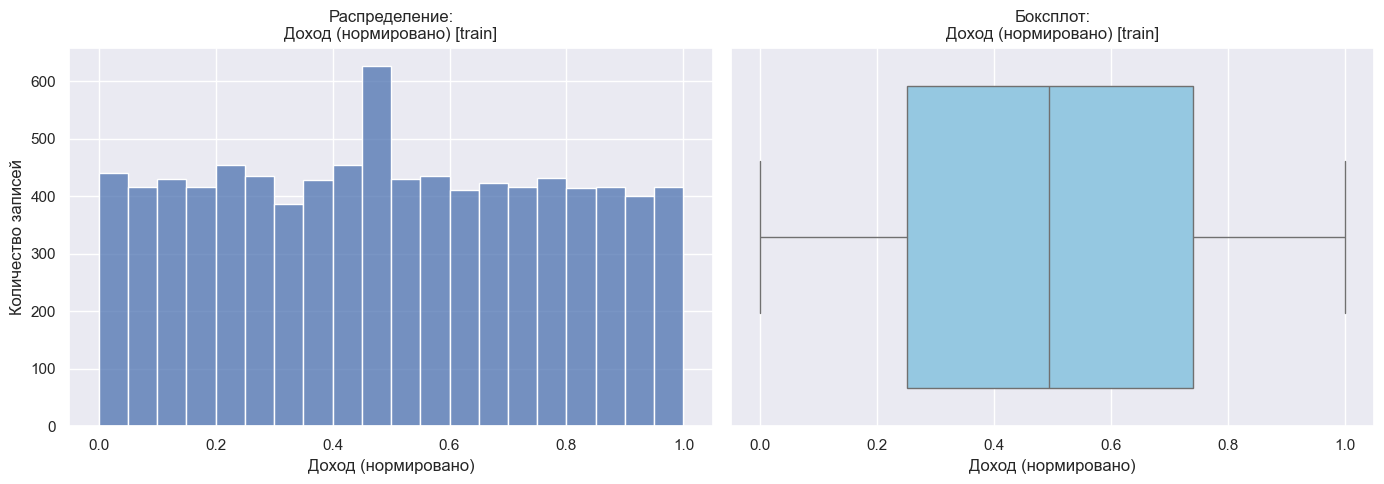

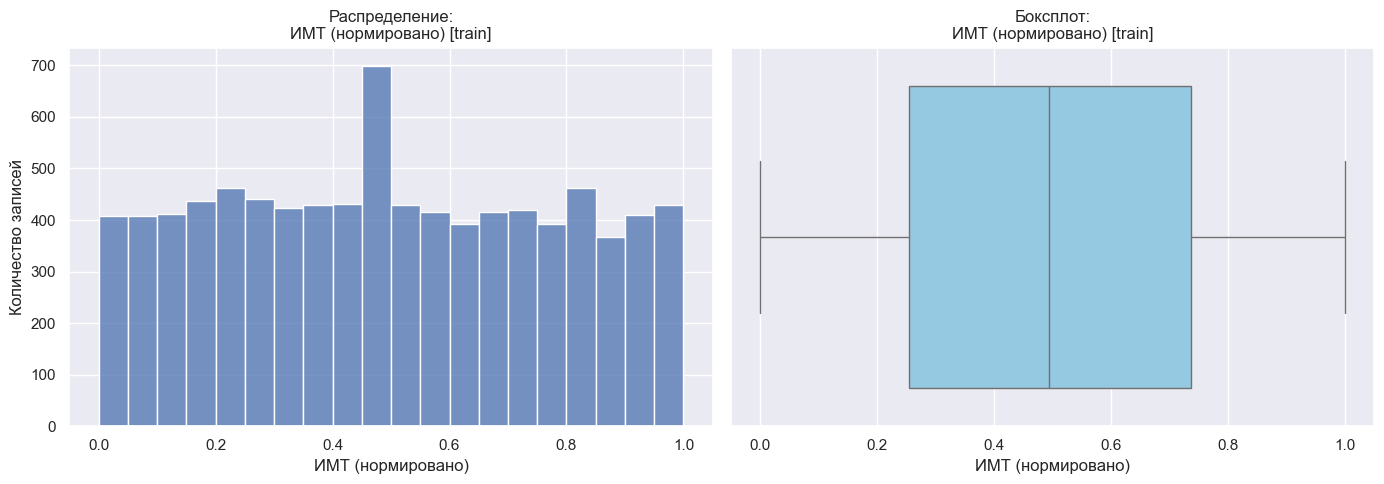

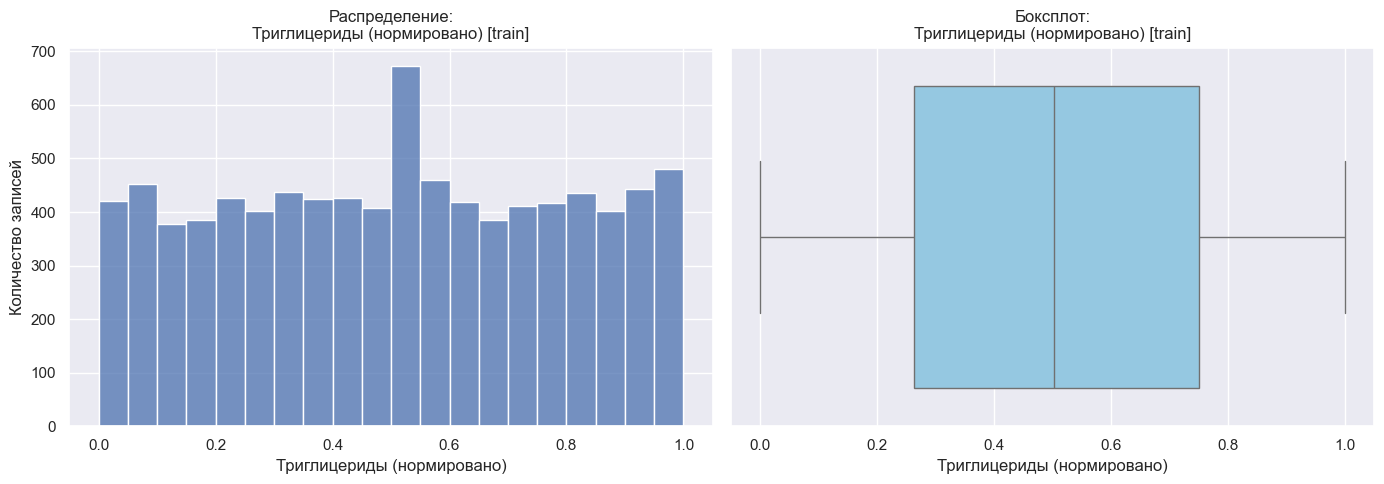

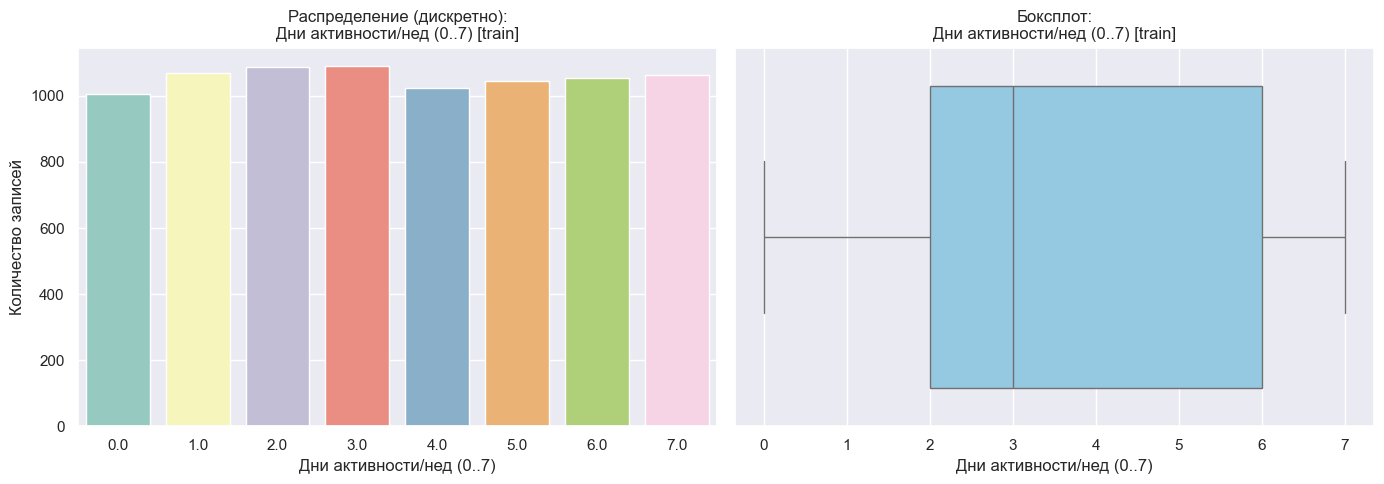

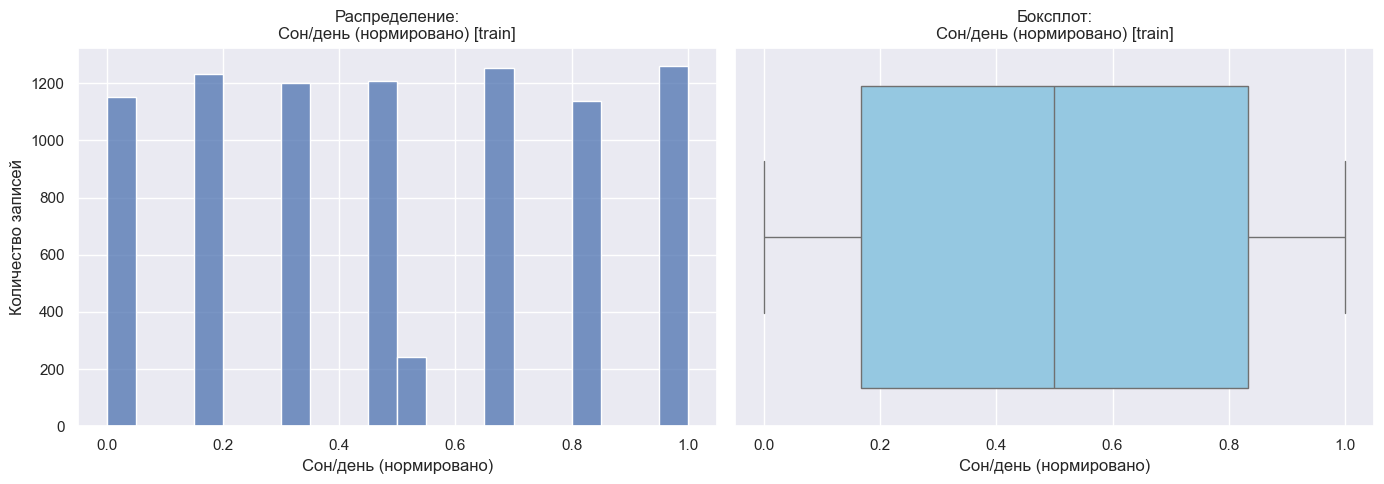

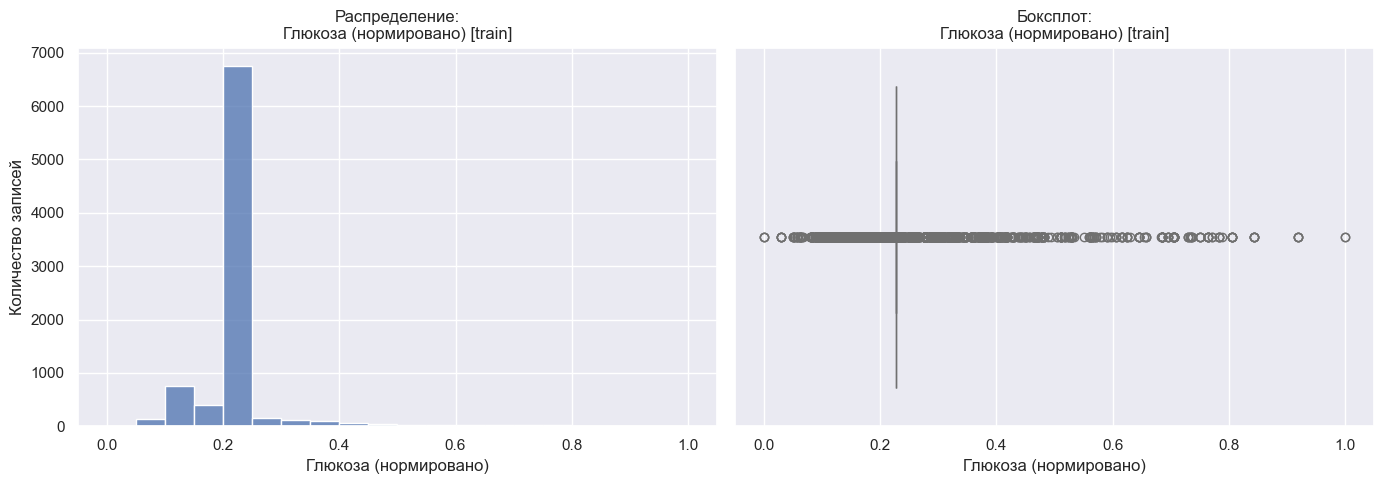

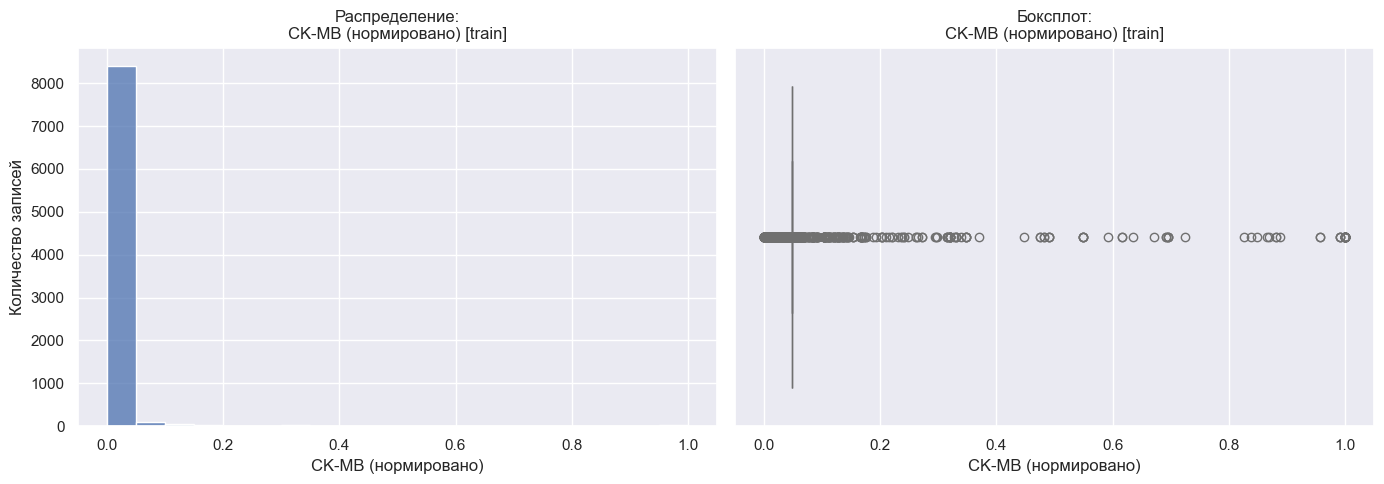

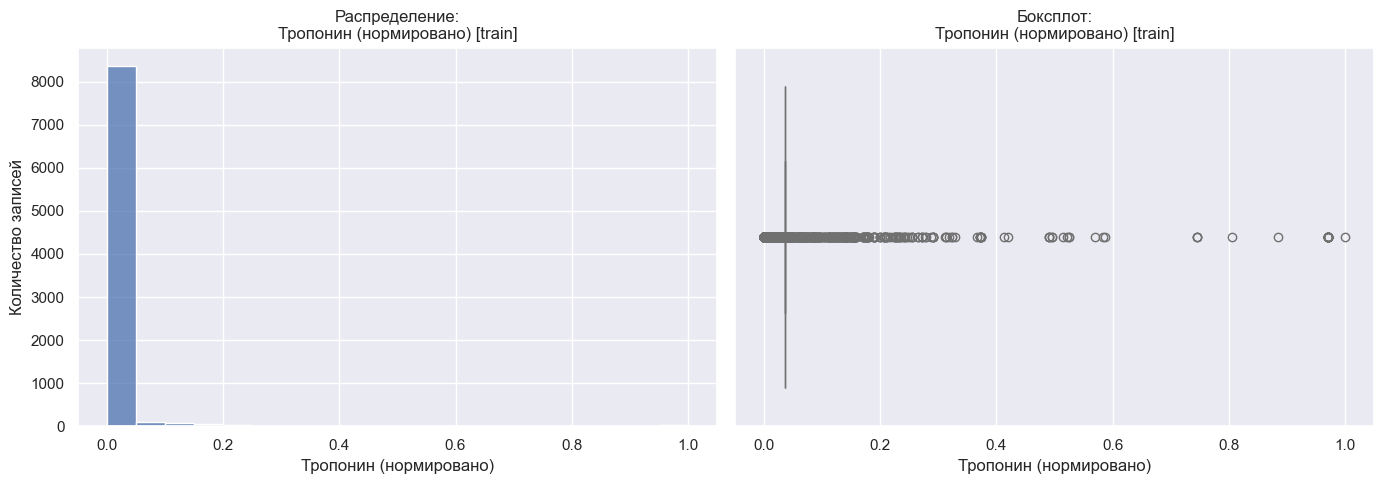

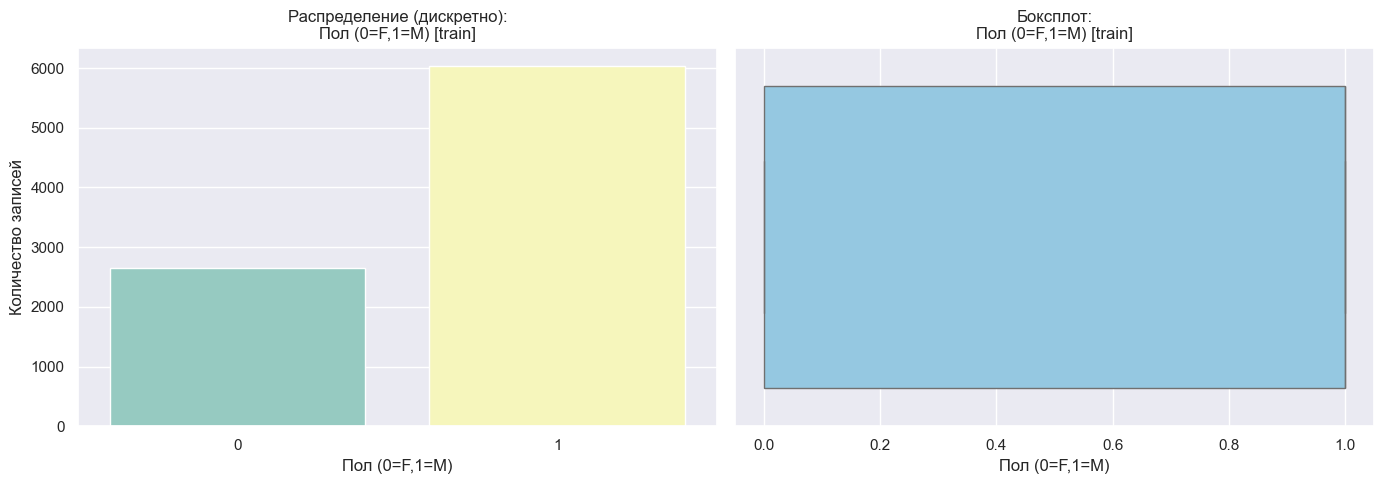

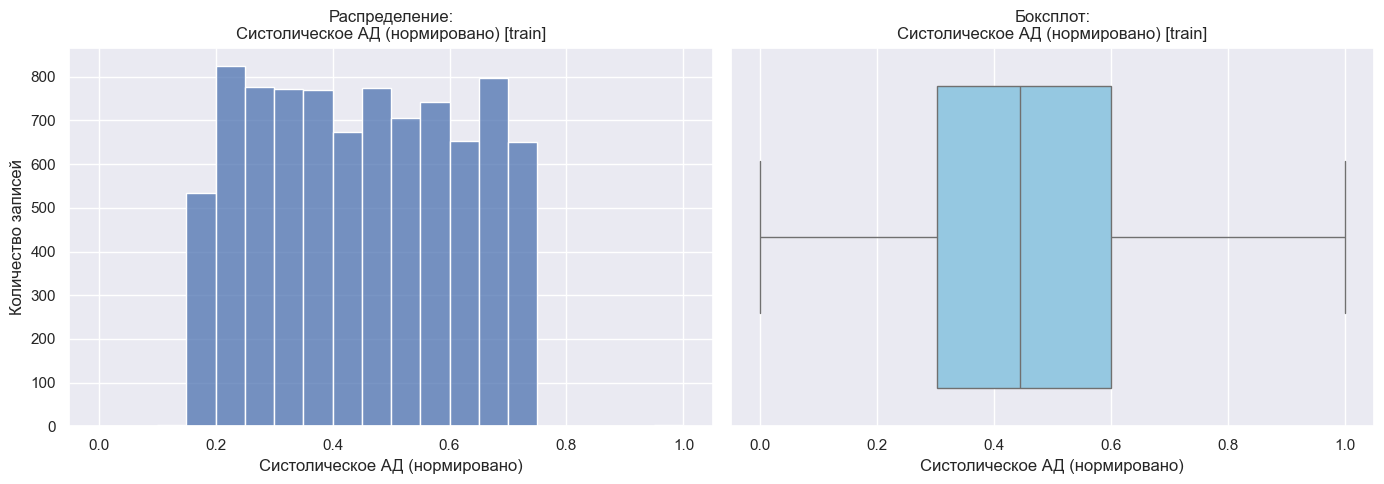

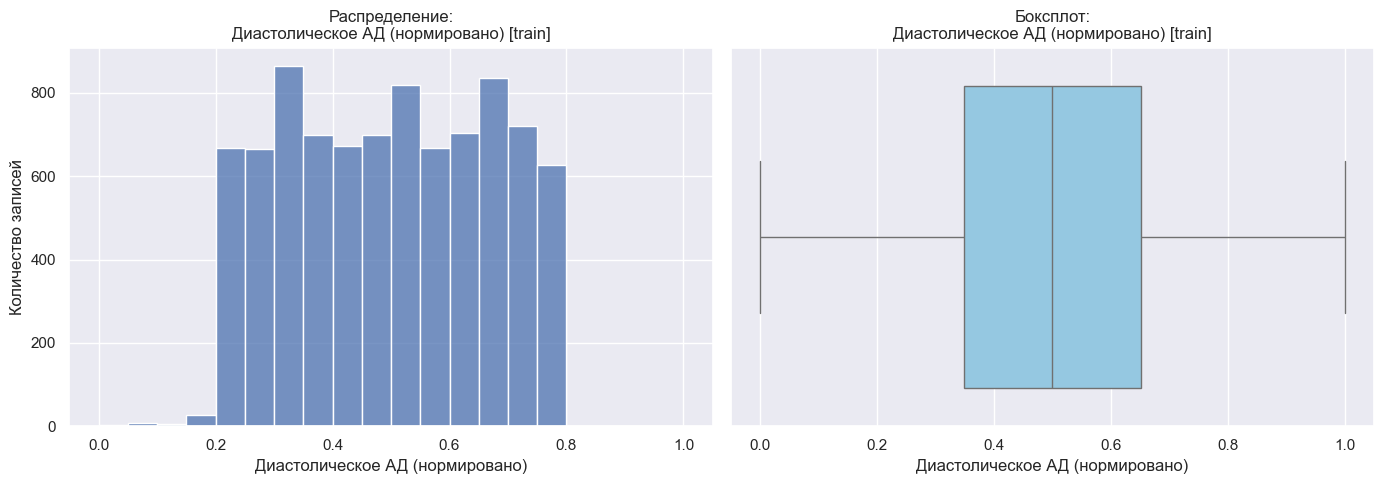

In [33]:
TARGET_COL = "heart_attack_risk_binary"

# 1) эвристика дискретности (как и раньше)
def is_binary_feature(s: pd.Series) -> bool:
    vals = set(pd.to_numeric(s.dropna(), errors="coerce").unique().tolist())
    return len(vals) <= 2 and vals.issubset({0, 1})

def is_discrete_feature(s: pd.Series, threshold: int = 15) -> bool:
    if is_binary_feature(s):
        return True
    nunique_ok = s.nunique(dropna=True) < threshold
    if is_integer_dtype(s):
        return nunique_ok
    s_num = pd.to_numeric(s.dropna(), errors="coerce")
    all_int_like = (s_num == np.floor(s_num)).all()
    return nunique_ok and bool(all_int_like)

# 2) красивые подписи (дополни по вкусу)
axis_labels = {
    "age": "Возраст (нормировано)",
    "cholesterol": "Холестерин (нормировано)",
    "heart_rate": "ЧСС (нормировано)",
    "diabetes": "Сахарный диабет (0/1)",
    "family_history": "Семейный анамнез (0/1)",
    "smoking": "Курение (0/1)",
    "obesity": "Ожирение (0/1)",
    "alcohol_consumption": "Потребление алкоголя (0/1)",
    "exercise_hours_per_week": "Часы активности/нед (нормировано)",
    "diet": "Диета (0..3)",
    "previous_heart_problems": "Проблемы с сердцем ранее (0/1)",
    "medication_use": "Приём лекарств (0/1)",
    "stress_level": "Уровень стресса (1..10)",
    "sedentary_hours_per_day": "Сидячие часы/день (нормировано)",
    "income": "Доход (нормировано)",
    "bmi": "ИМТ (нормировано)",
    "triglycerides": "Триглицериды (нормировано)",
    "physical_activity_days_per_week": "Дни активности/нед (0..7)",
    "sleep_hours_per_day": "Сон/день (нормировано)",
    "blood_sugar": "Глюкоза (нормировано)",
    "ck_mb": "CK-MB (нормировано)",
    "troponin": "Тропонин (нормировано)",
    "gender": "Пол (0=F,1=M)",
    "systolic_blood_pressure": "Систолическое АД (нормировано)",
    "diastolic_blood_pressure": "Диастолическое АД (нормировано)",
}

# 3) удобная палитра «по числу столбиков»
def palette_for_k(k: int):
    # tab20 до 20, дальше — husl
    if k <= 12:
        return sns.color_palette("Set3", k)
    elif k <= 20:
        return sns.color_palette("tab20", k)
    else:
        return sns.color_palette("husl", k)

# 4) построение графиков
def plot_feature_distributions(df: pd.DataFrame, dataset_name: str = "train", with_hue: bool = False):
    num_cols = df.select_dtypes(include="number").columns.tolist()
    # исключаем id/target (если вдруг присутствуют)
    num_cols = [c for c in num_cols if c.lower() not in ("id",)]
    if TARGET_COL in num_cols:
        num_cols.remove(TARGET_COL)

    for col in num_cols:
        s = df[col]
        label = axis_labels.get(col, col)

        fig, axes = plt.subplots(1, 2, figsize=(14, 5))

        if is_discrete_feature(s, threshold=15):
            # порядок категорий (отсортированный)
            cats = sorted(s.dropna().unique().tolist())
            pal = palette_for_k(len(cats))

            if with_hue and TARGET_COL in df.columns:
                # Раскраска по таргету (столбики внутри каждой категории)
                sns.countplot(
                    data=df, x=col, hue=TARGET_COL,
                    order=cats, palette="Set2", ax=axes[0]
                )
                axes[0].legend(title="target", loc="best")
            else:
                # Каждый столбик своим цветом
                sns.countplot(
                    data=df, x=col,
                    order=cats, palette=pal, ax=axes[0]
                )

            axes[0].set_title(f"Распределение (дискретно):\n{label} [{dataset_name}]")
            axes[0].set_xlabel(label)
            axes[0].set_ylabel("Количество записей")
        else:
            # непрерывное — обычная гистограмма
            sns.histplot(s.dropna(), bins=20, kde=False, ax=axes[0], color="#4C72B0")
            axes[0].set_title(f"Распределение:\n{label} [{dataset_name}]")
            axes[0].set_xlabel(label)
            axes[0].set_ylabel("Количество записей")

        # Боксплот (единый)
        sns.boxplot(x=s, ax=axes[1], color="#88CCEE")
        axes[1].set_title(f"Боксплот:\n{label} [{dataset_name}]")
        axes[1].set_xlabel(label)

        plt.tight_layout()
        plt.show()

# --- запуск для train ---
plot_feature_distributions(heart_train, dataset_name="train", with_hue=False)

Анализ признаков по типам
1. Бинарные признаки
Примеры: gender, diabetes, family_history, smoking, obesity, alcohol_consumption и др.

Распределение:

gender — доля мужчин значительно выше (~72%), что создаёт дисбаланс.

У некоторых других бинарных фичей (например, smoking) также наблюдается перекос в сторону одного класса.

Пропуски: Визуально на countplot не видны, но ранее зафиксированы групповые NaN в одних и тех же записях.

📌 Вывод:

Дисбаланс нужно учесть при обучении (стратификация или взвешивание классов).

Для NaN — целесообразно заполнение модой или target-based иммутацией.

2. Порядковые признаки
Примеры: stress_level, diet, physical_activity_days_per_week.

Распределение:

physical_activity_days_per_week — заметен пик на нуле (полное отсутствие активности).

diet — редкие высокие значения (3), которые могут быть как выбросами, так и признаком малой подгруппы.

📌 Вывод:

Оставляем в исходном виде.

При импутации — медиана или частое значение по классу.

3. Непрерывные признаки
Примеры: age, cholesterol, heart_rate, bmi, triglycerides, systolic_bp, diastolic_bp, glucose, ck_mb, troponin.

Распределения:

age — смещение в сторону старших пациентов.

systolic_bp и diastolic_bp — равномерные распределения, выбросов почти нет.

cholesterol — умеренно симметричен, редкие выбросы.

glucose — скошен вправо, есть значимые выбросы в верхнем диапазоне.

ck_mb и troponin — очень сильный правый перекос, множество выбросов, >95% значений близки к нулю.

📌 Вывод:

Для ck_mb, troponin, glucose рекомендуется логарифмическая трансформация или квантильное масштабирование.

Для остальных непрерывных — можно оставить как есть (данные уже нормированы).

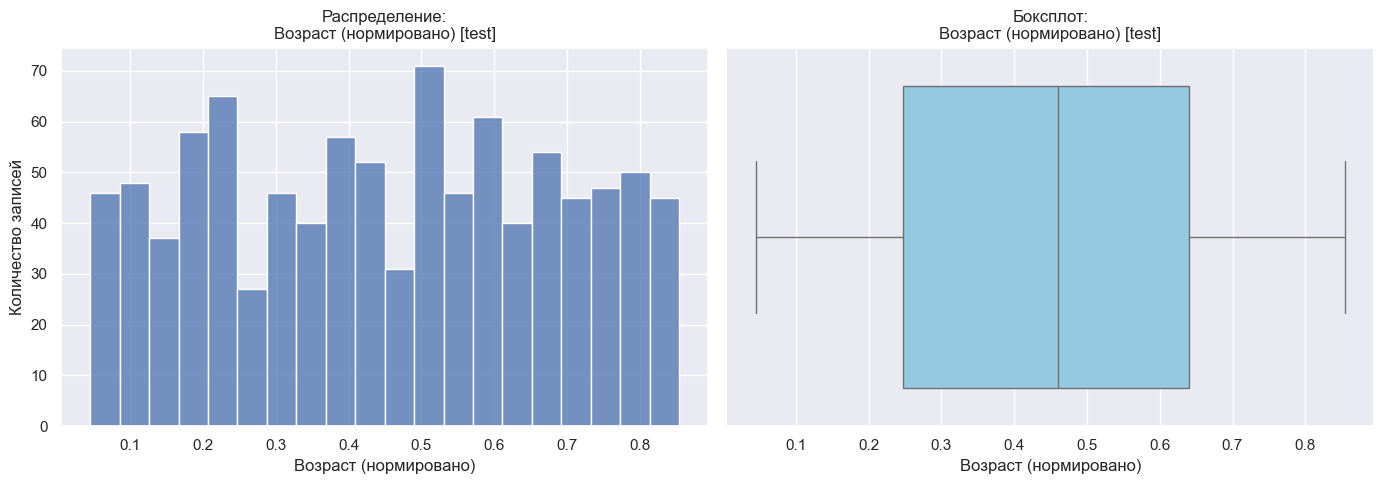

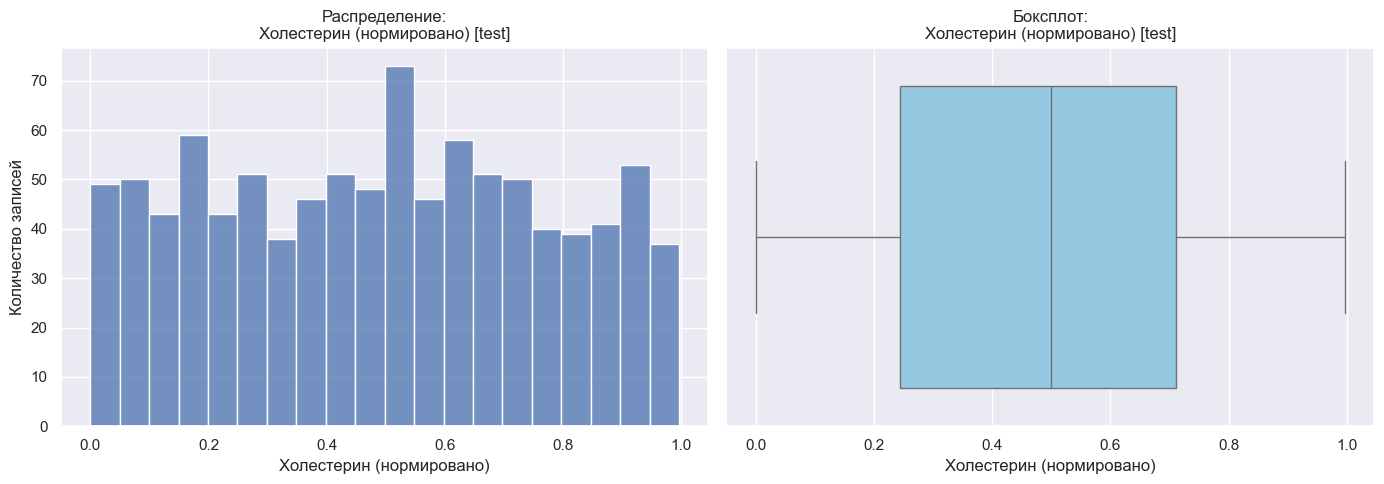

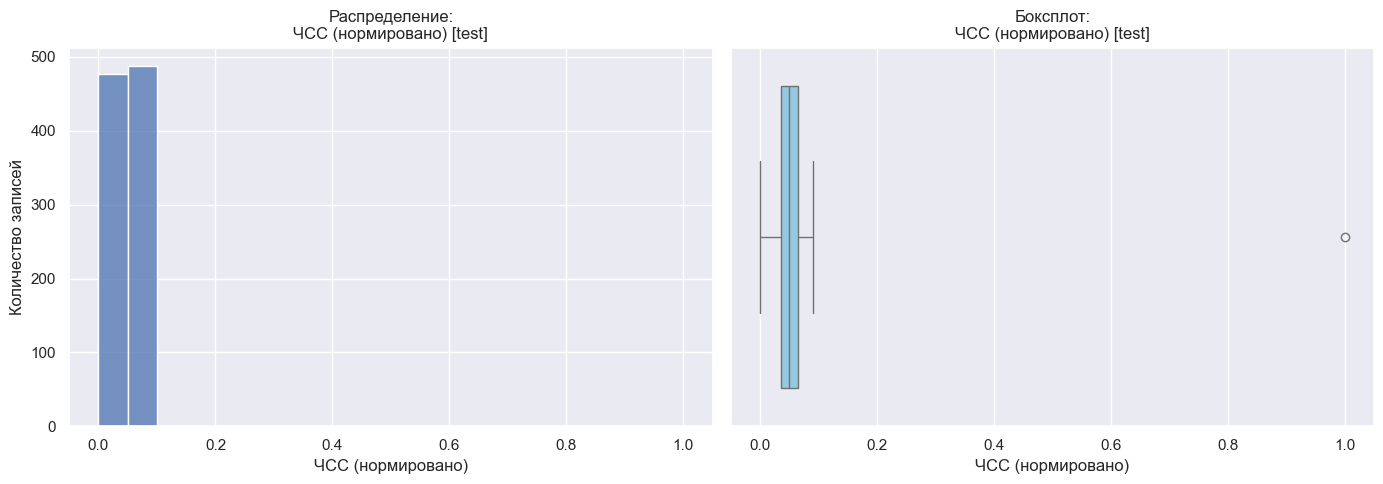

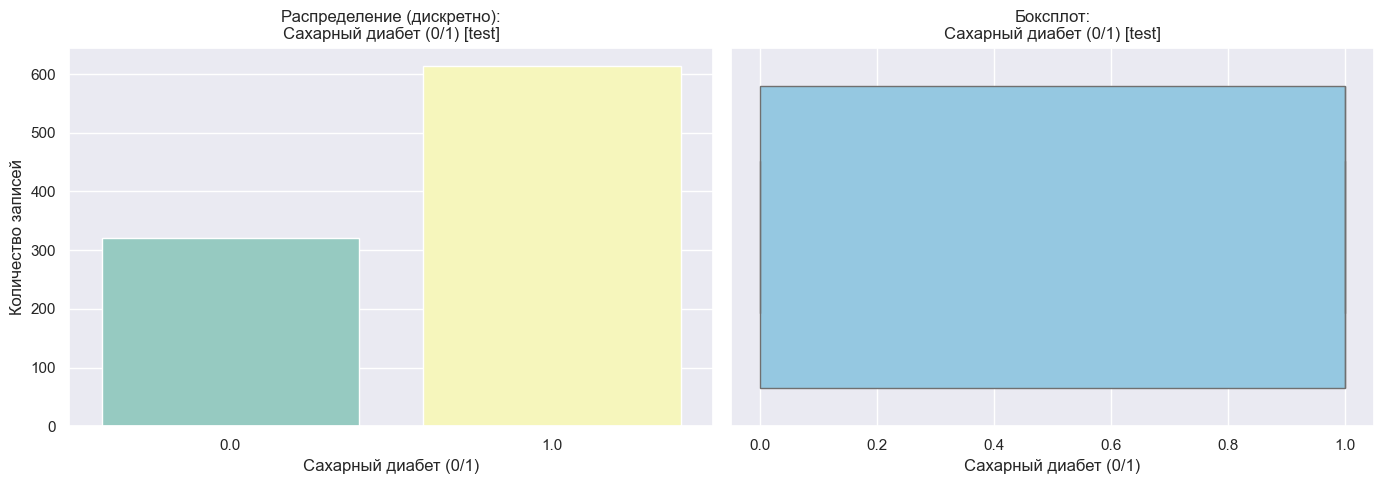

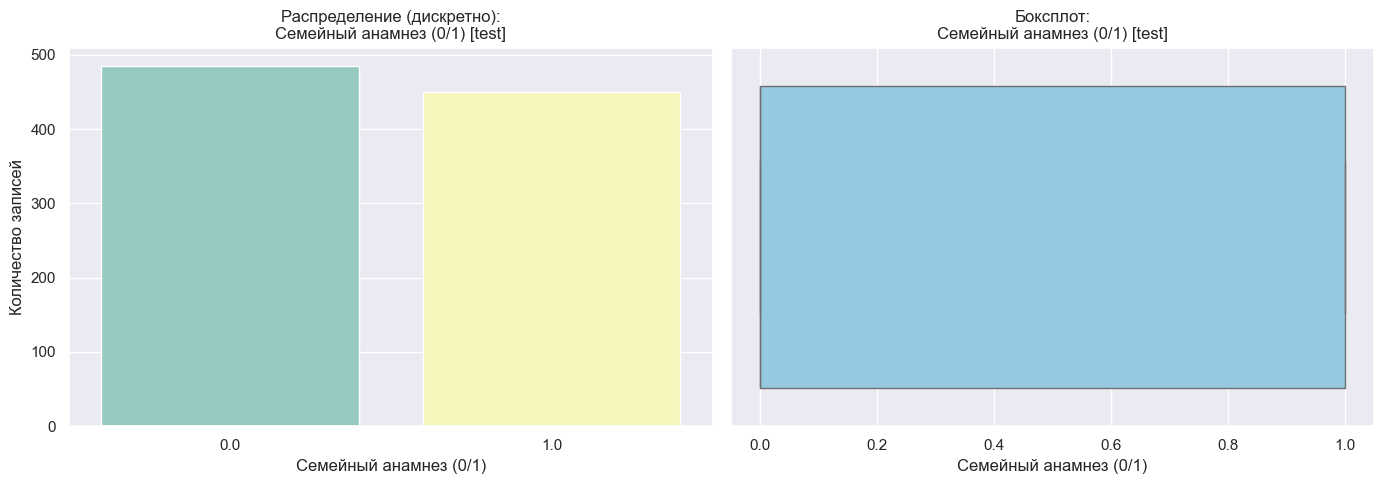

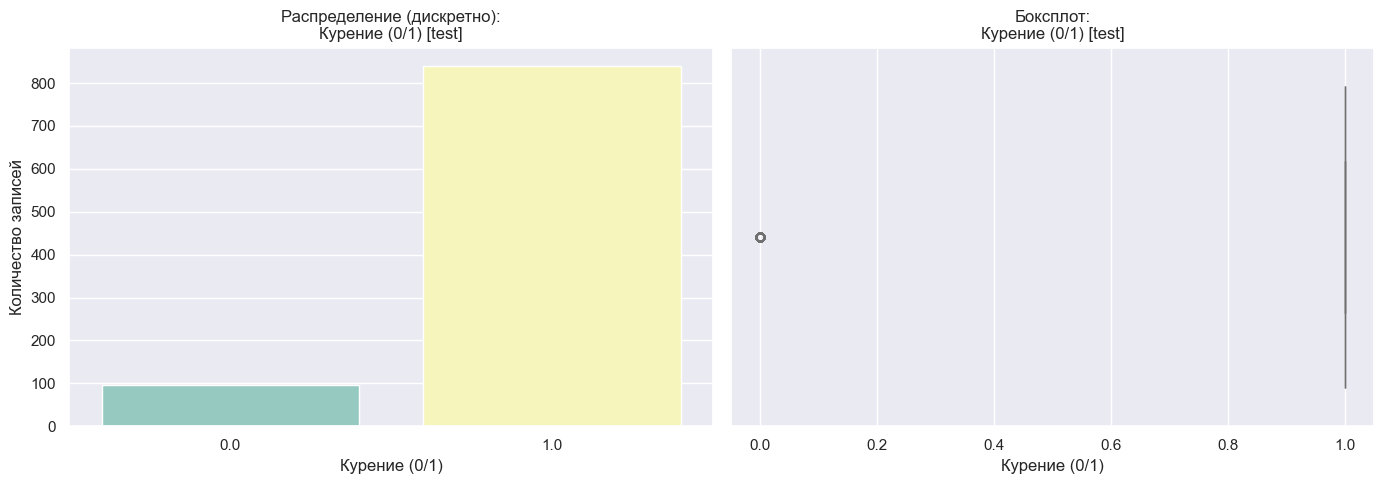

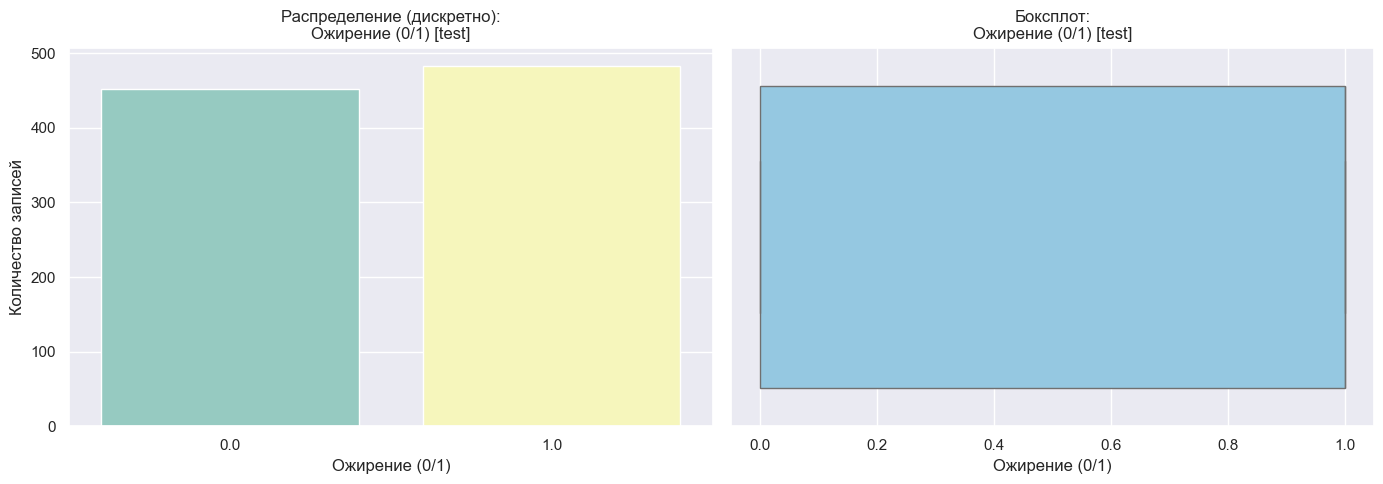

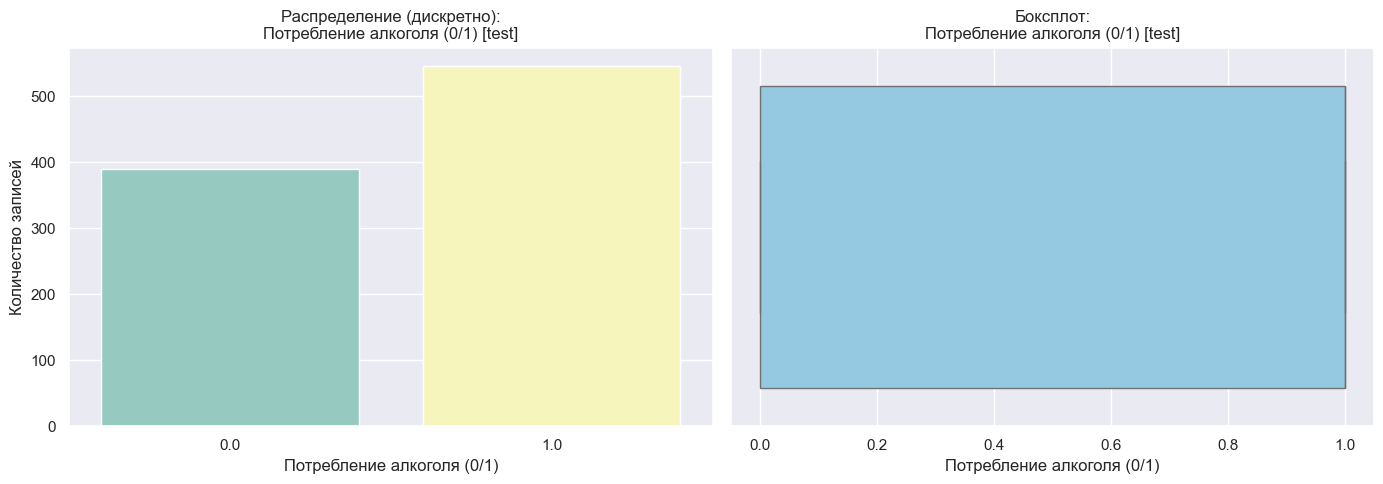

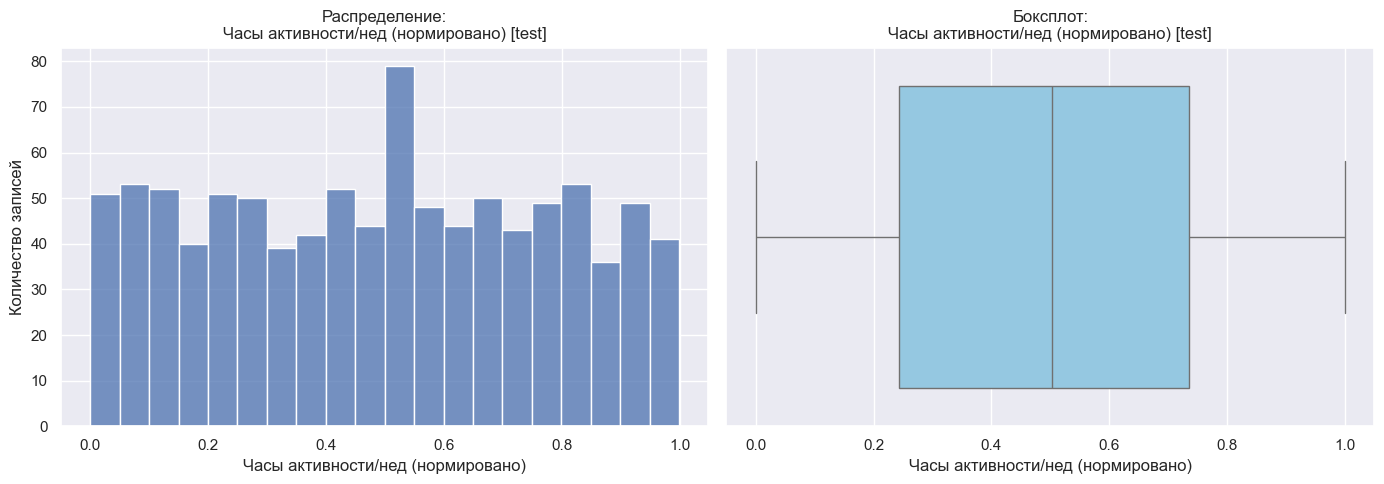

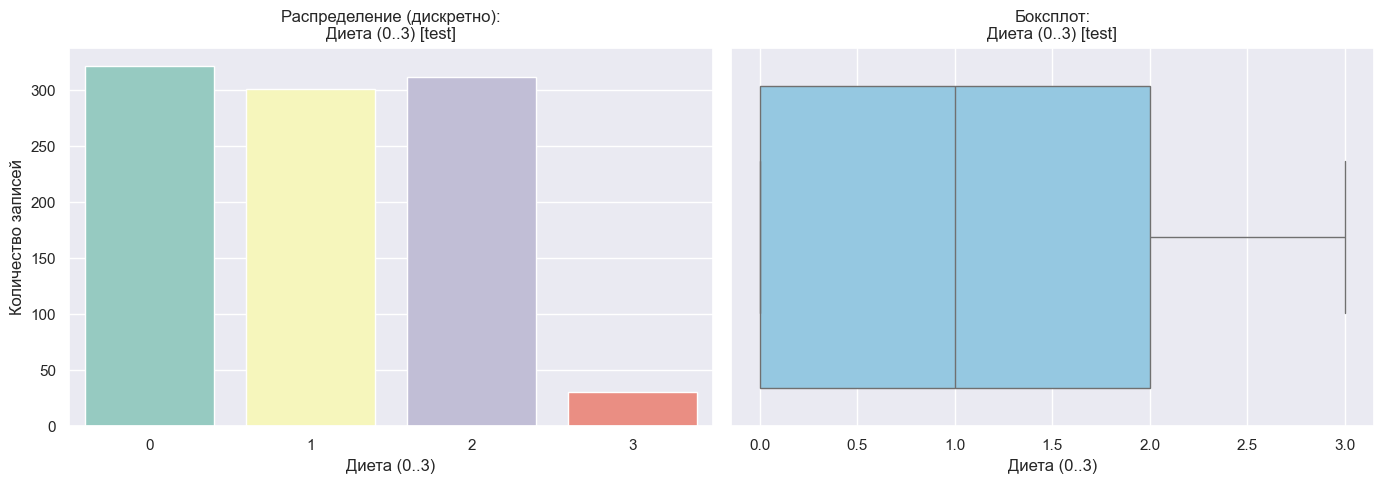

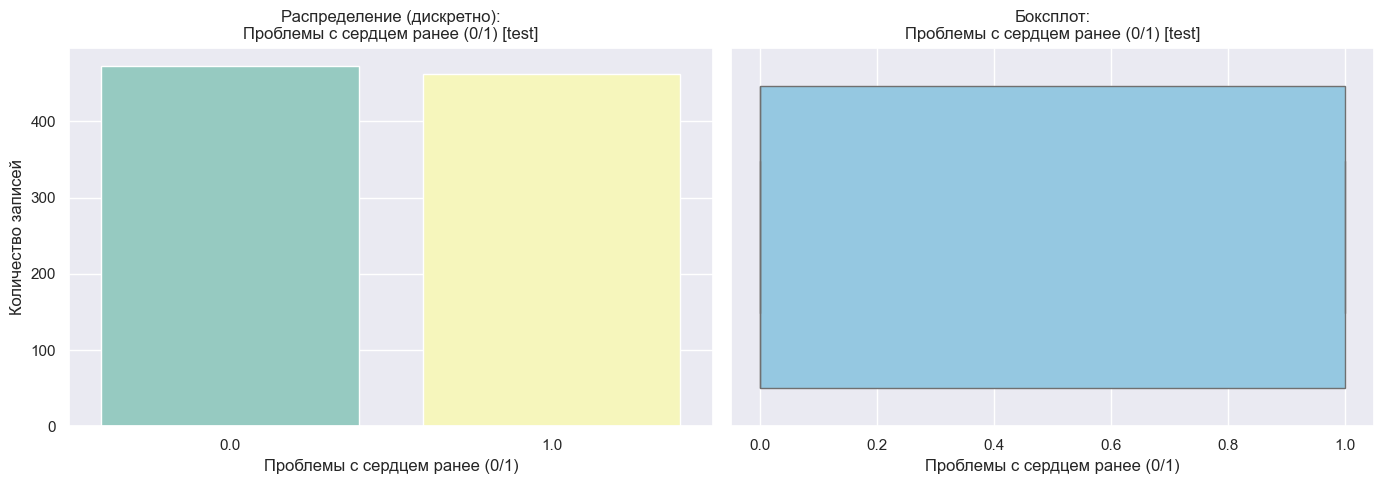

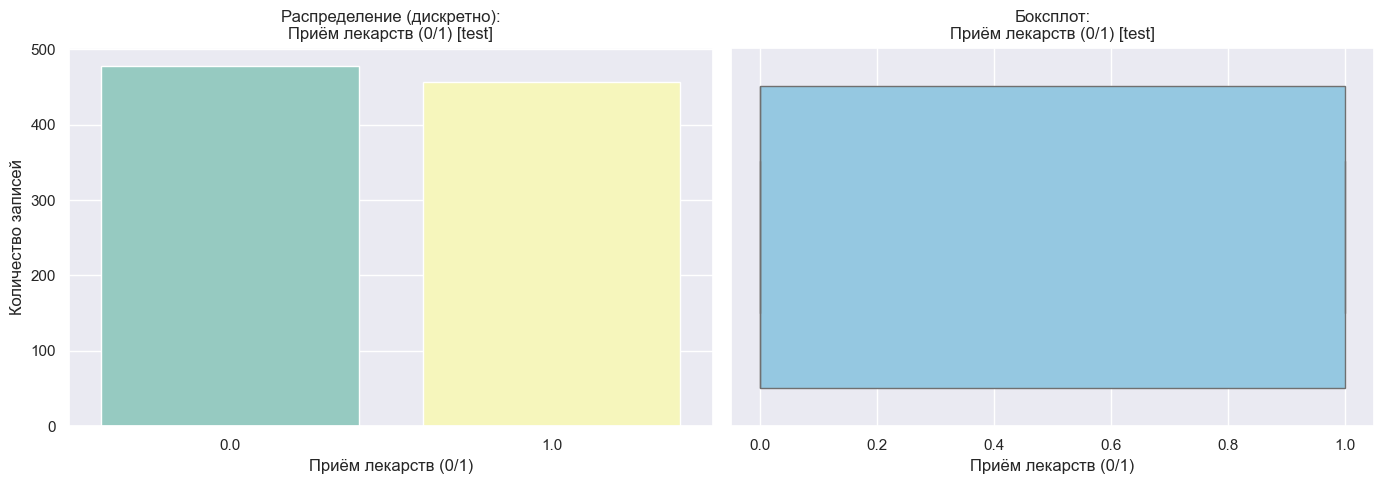

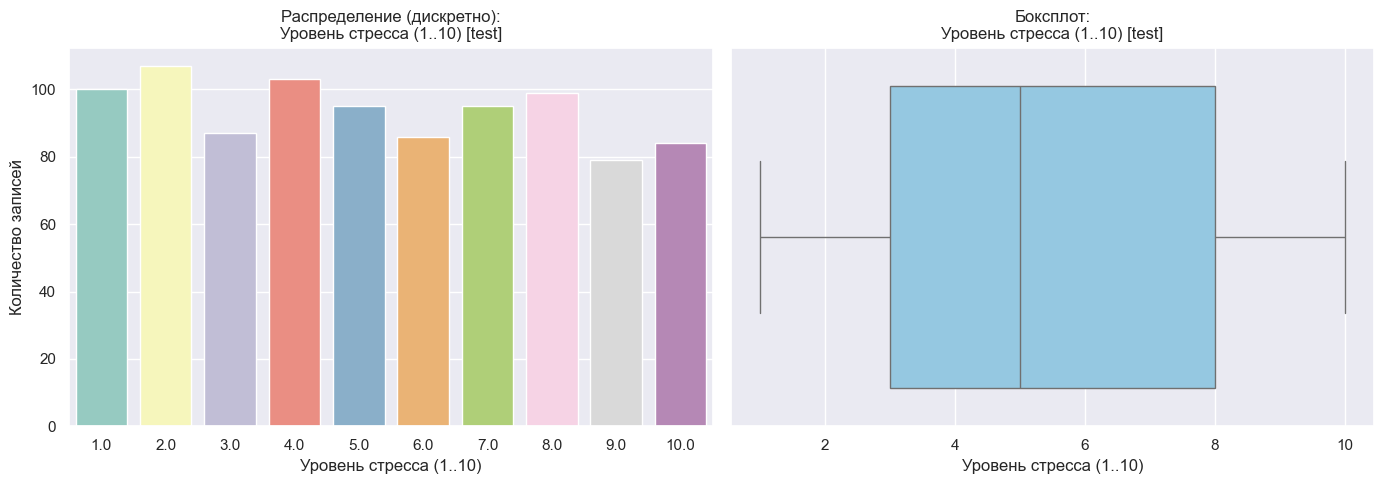

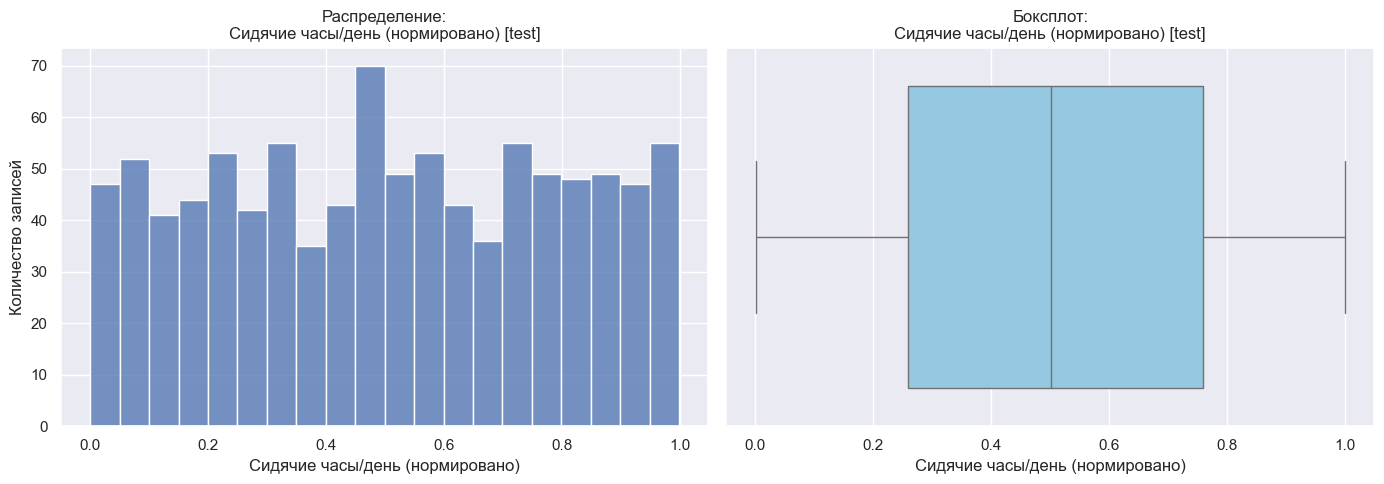

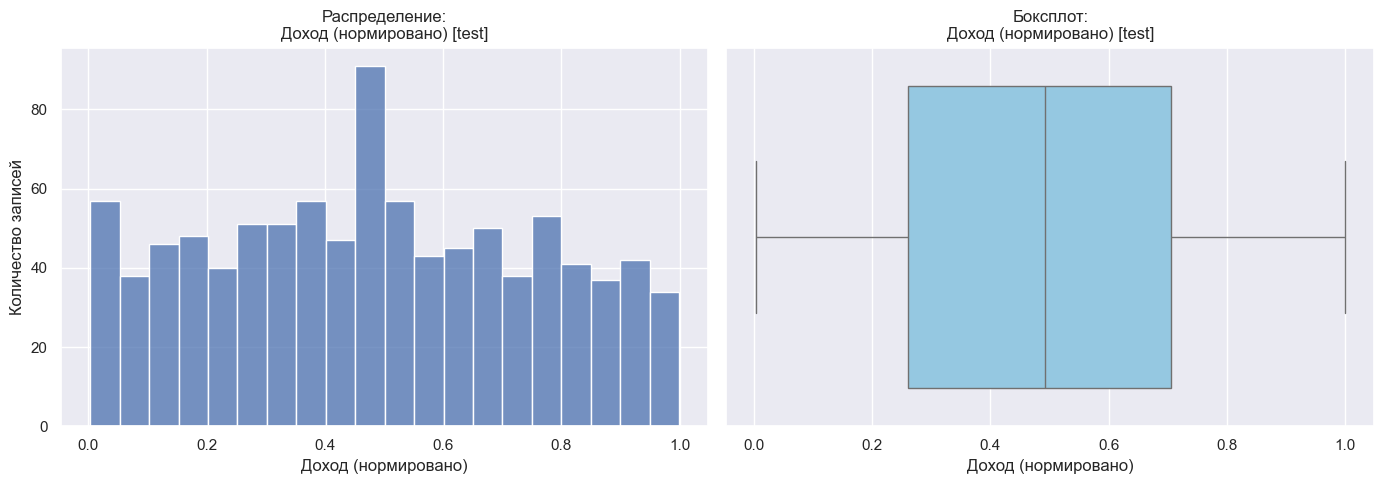

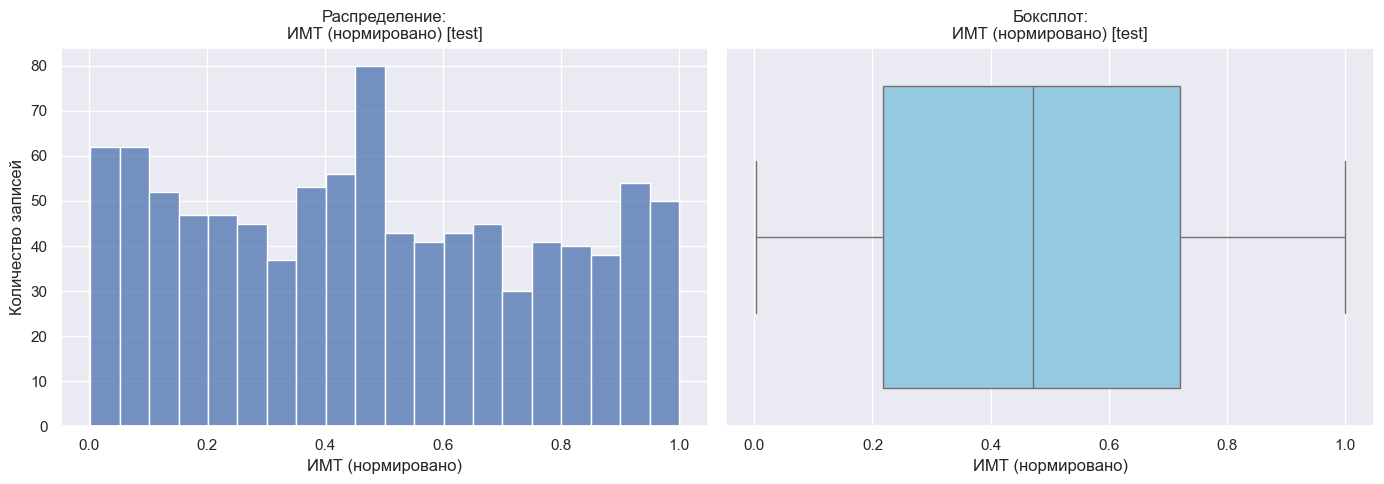

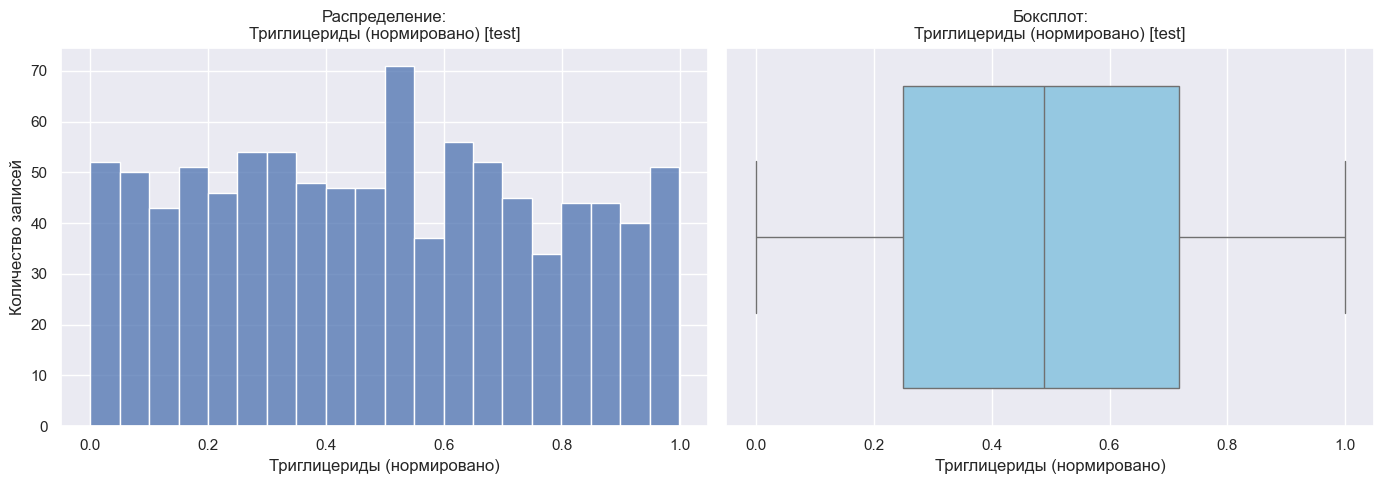

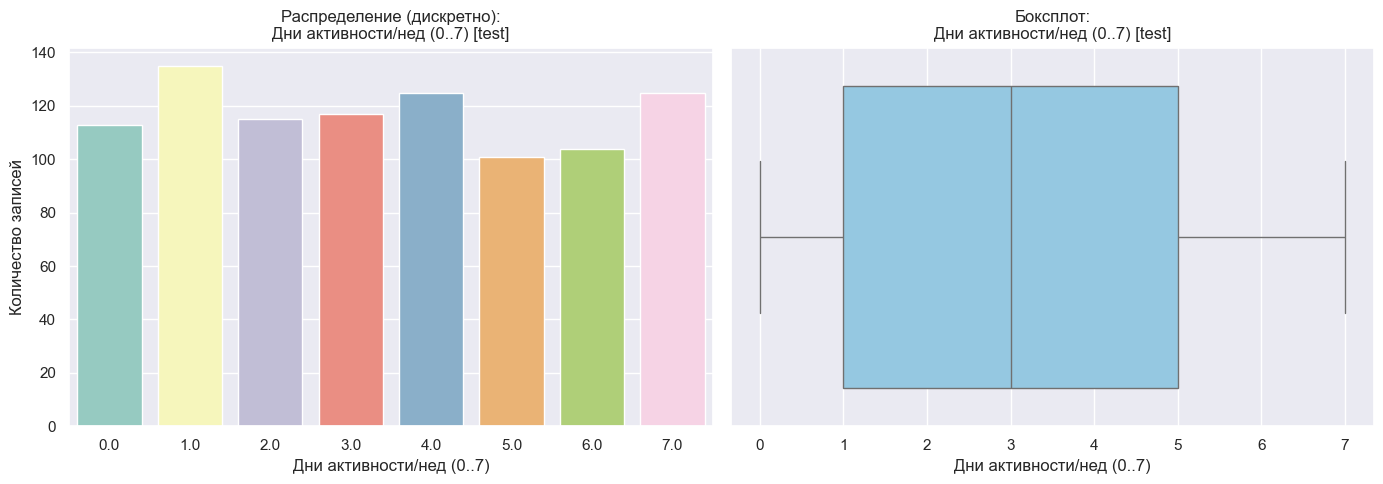

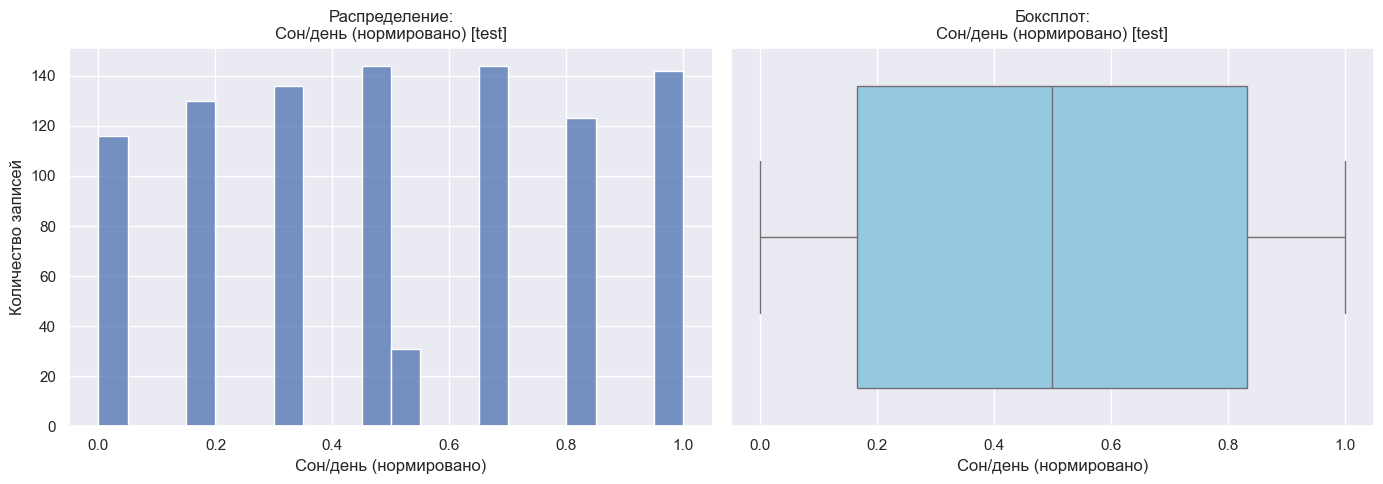

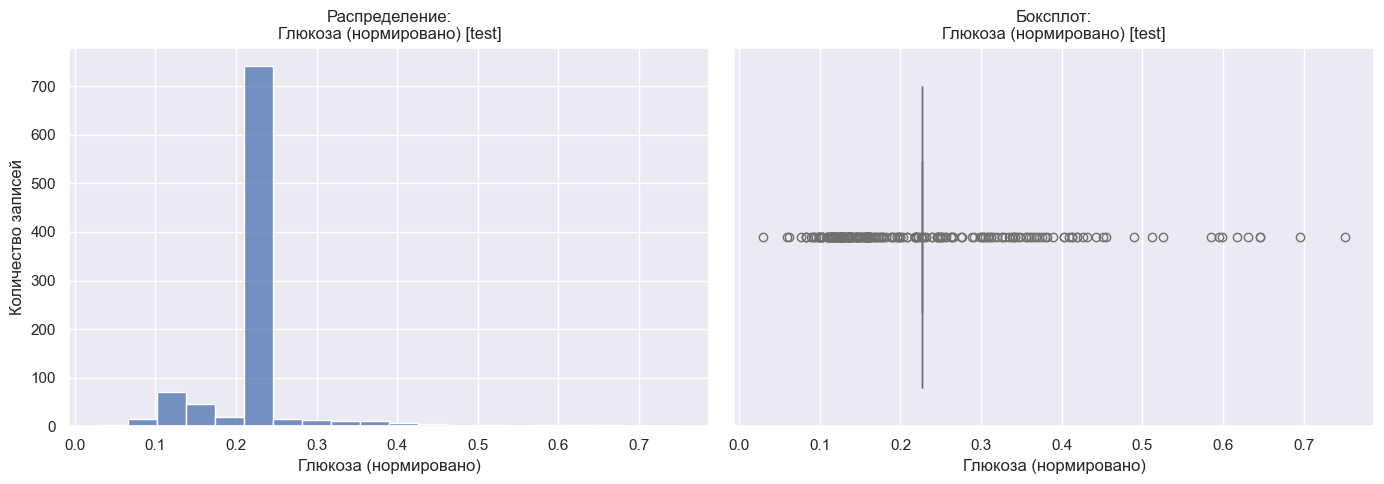

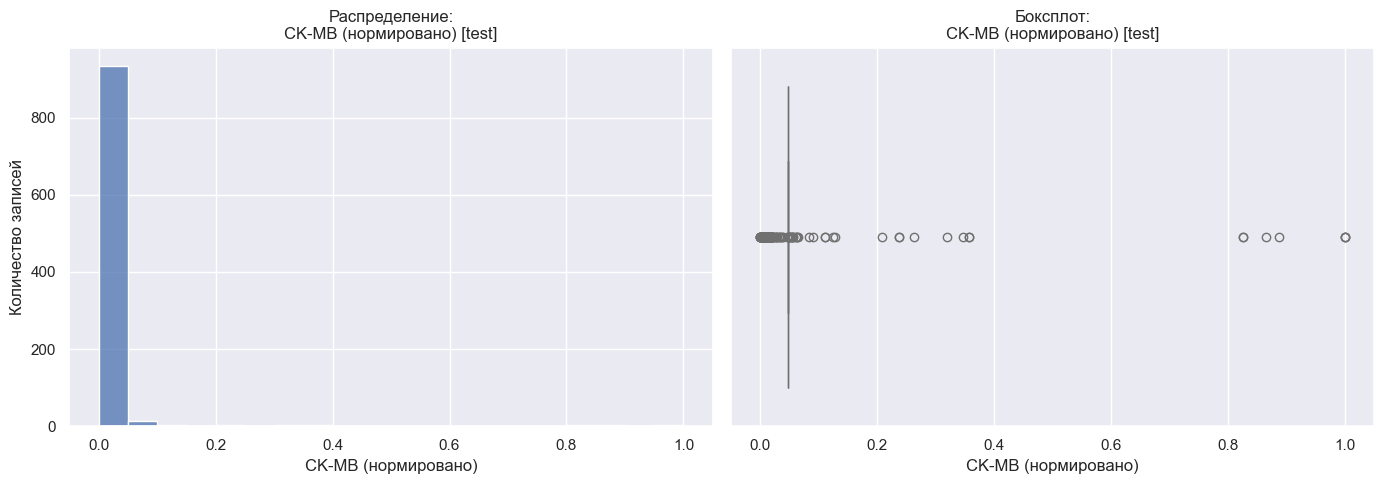

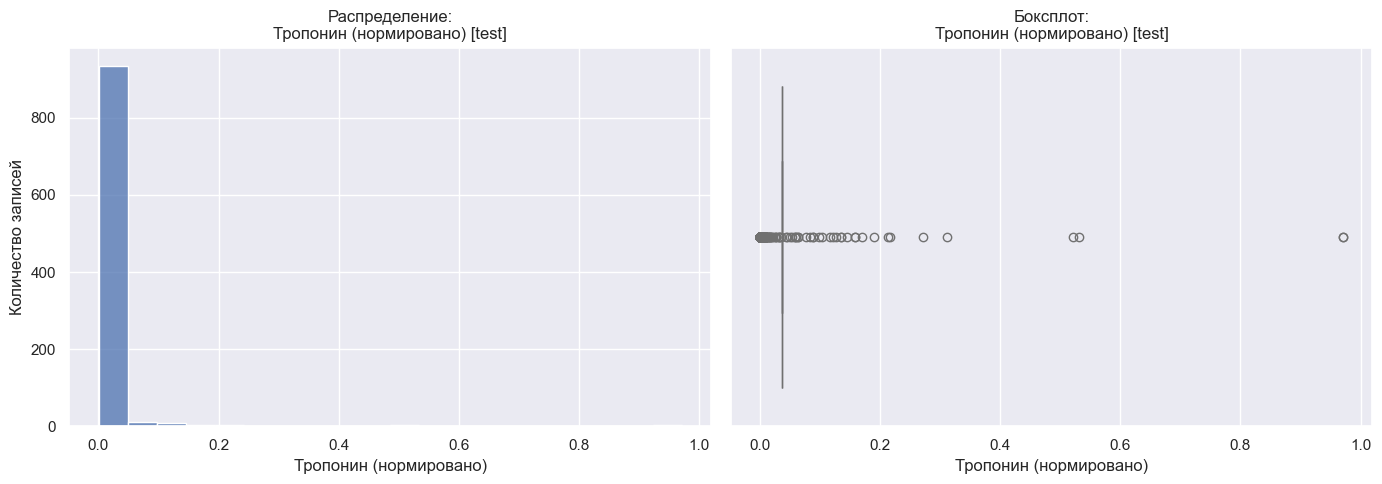

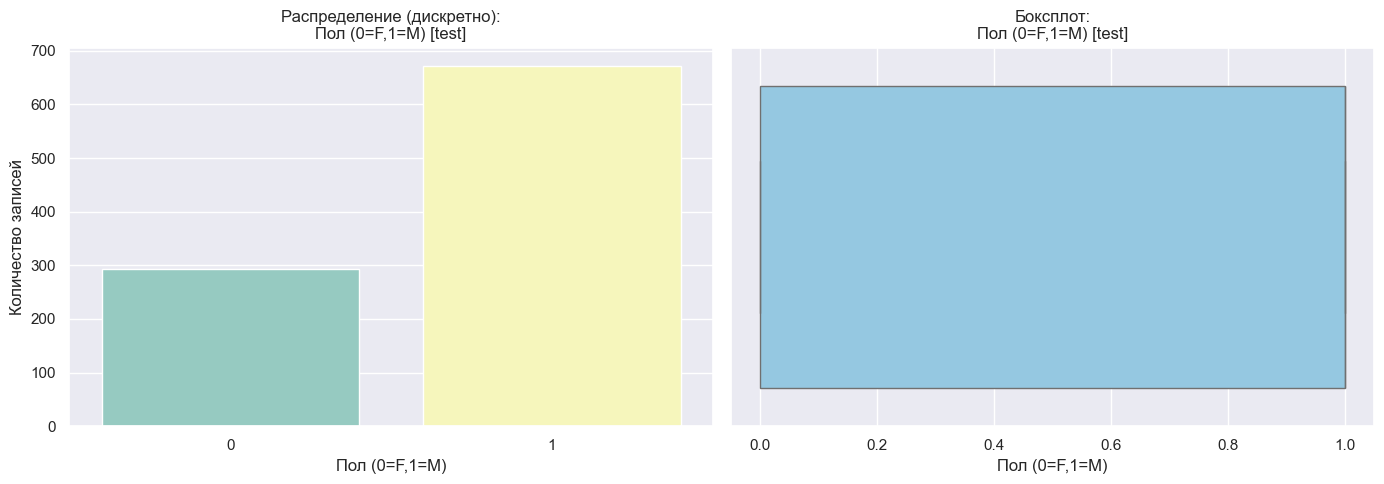

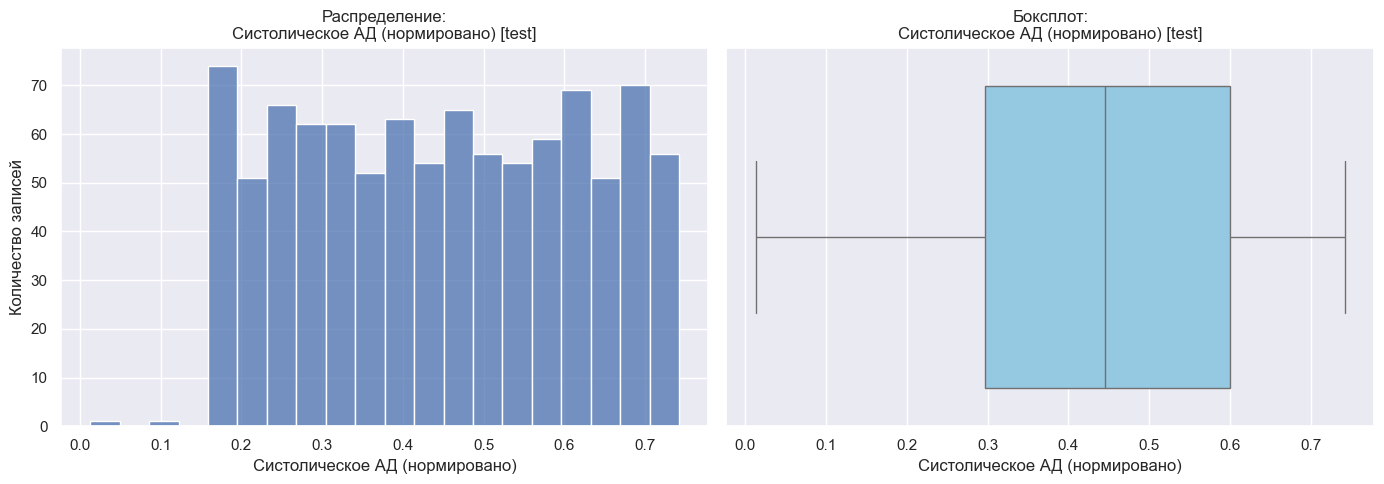

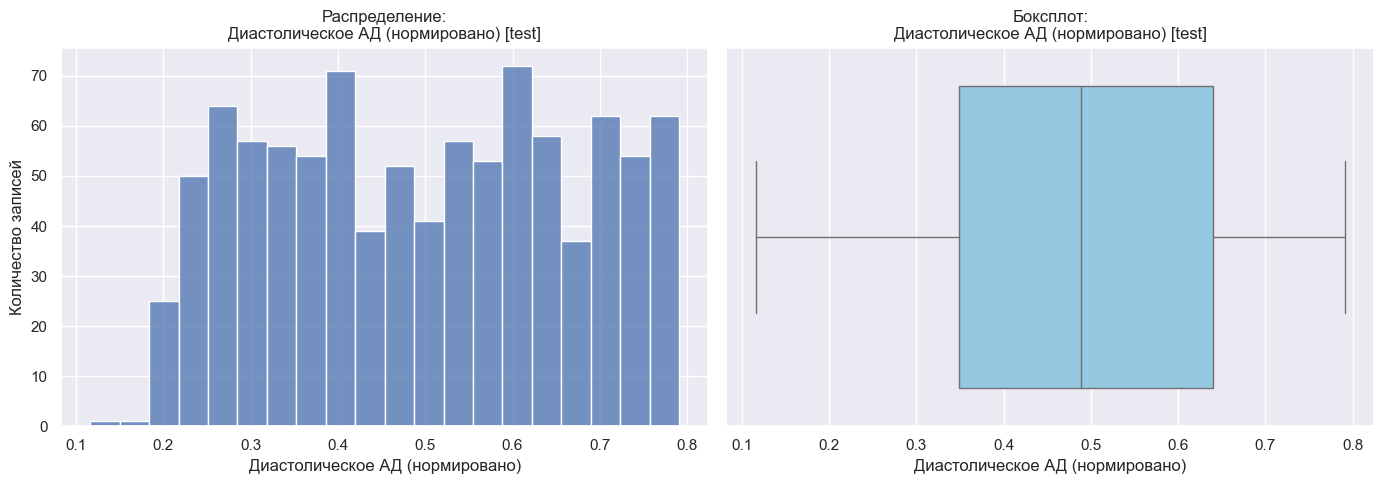

In [34]:
plot_feature_distributions(heart_test, dataset_name="test", with_hue=False)

1. Бинарные признаки
gender:

В обоих наборах мужчин заметно больше, чем женщин.

Доля мужчин в test немного выше, чем в train, но разница не критична.

другие бинарные признаки (например, smoking, diabetes, если присутствуют в тесте):

Общий тренд похож — классы дисбалансированы, но структура дисбаланса сохраняется.

📌 Вывод: распределения бинарных признаков между train и test схожи, модель не должна испытывать проблем из-за этого.

2. Непрерывные признаки (уже нормированы)
Систолическое АД:

Train и test имеют почти равномерное распределение от 0.2 до 0.8, без значительных выбросов.

Диастолическое АД:

Сходная картина в обеих выборках, разброс и медианы совпадают.

📌 Вывод: существенного сдвига распределения нет.

3. Биомаркеры (CK-MB, Troponin)
В обоих наборах распределения крайне скошены влево (основная масса значений около 0).

Количество выбросов в test чуть меньше, чем в train, что может говорить о меньшей доле пациентов в острой фазе заболевания.

📌 Вывод: распределения совпадают по форме, но частота высоких значений в test чуть ниже. Это может немного снизить чувствительность модели на тесте к выявлению тяжёлых случаев.

4. Признаки образа жизни
exercise_hours_per_week:

В train распределение более "сосредоточено" на среднем уровне активности, в test чуть более равномерно.

sleep_hours_per_day:

Почти одинаковые распределения в обеих выборках.

sedentary_hours_per_day:

В test немного больше значений в верхней части диапазона, что может говорить о более малоподвижной группе.

📌 Вывод: различия есть, но незначительные — вероятно, модель не потребует дополнительной адаптации.

5. Пропуски
И в train, и в test пропуски встречаются группами (одни и те же признаки пустые в одной записи).

Вероятно, это пациенты, у которых не проводились отдельные обследования.

📌 Вывод: выбранная для train стратегия импутации пропусков должна использоваться и для test, чтобы избежать смещения распределений.

##### Выводы исследовательского анализа

Данные чистые, без дубликатов, с системными пропусками, которые можно обрабатывать предсказуемо.
Распределения признаков между train и test в целом совпадают, что снижает риск снижения качества модели при переходе на тестовые данные.
Основные риски — дисбаланс некоторых бинарных признаков и сильная скошенность биомаркеров.
Рекомендация: сохранить стратегию импутации, учесть дисбаланс при обучении, добавить индикаторы пропусков и осторожно работать с выбросами биомаркеров.

#### Корреляционный анализ

##### Матрица корреляции

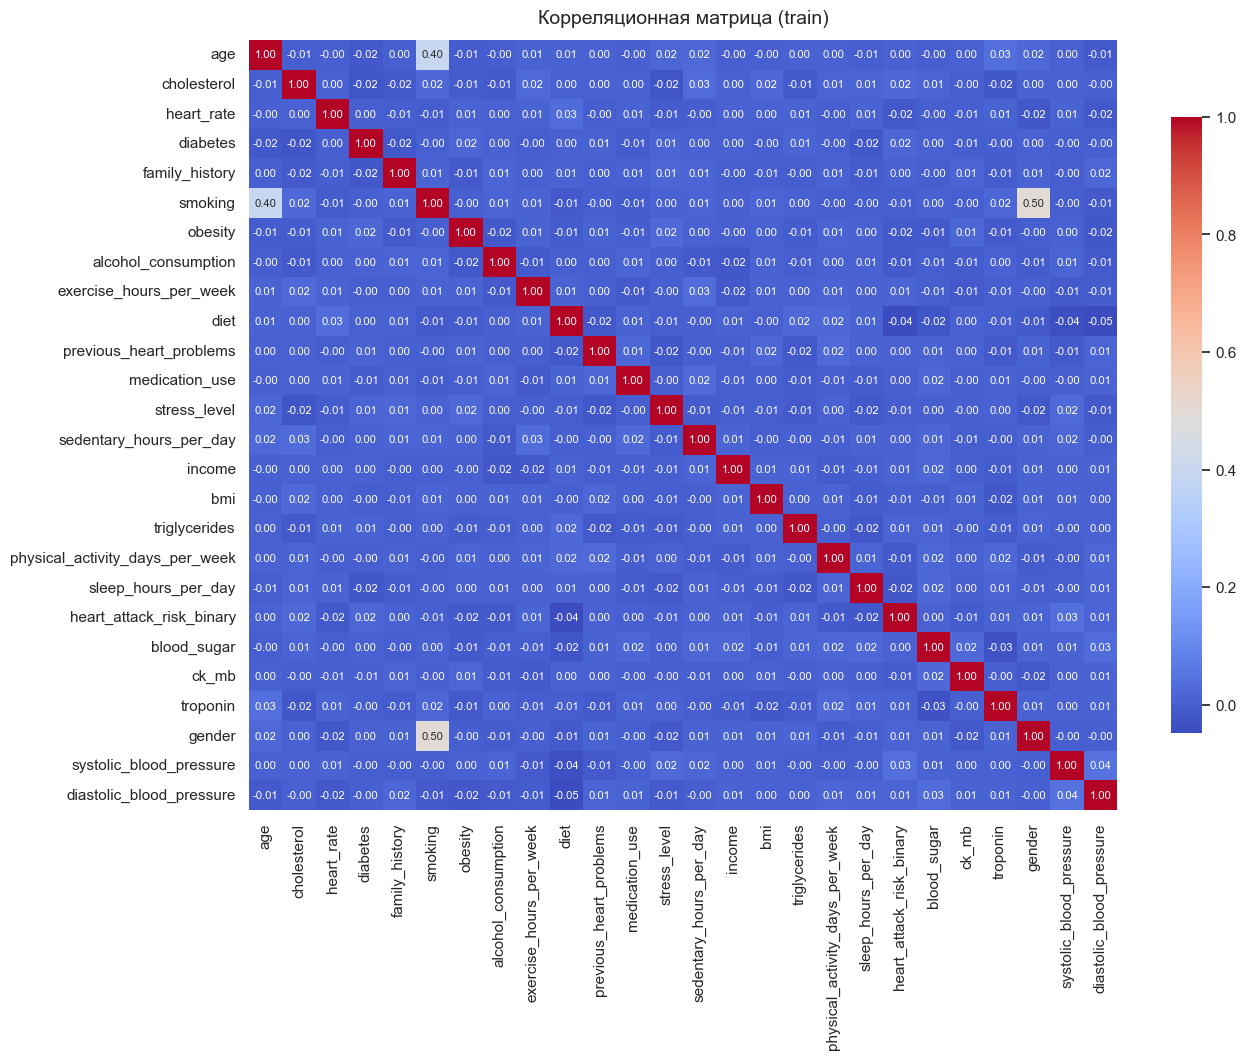

In [35]:
def plot_correlation_matrix(df, dataset_name="train"):
    # только числовые признаки
    num_df = df.select_dtypes(include='number')
    corr = num_df.corr()

    plt.figure(figsize=(14, 10))
    sns.heatmap(
        corr,
        cmap='coolwarm',
        annot=True,
        fmt=".2f",
        annot_kws={"size": 8},
        cbar_kws={'shrink': 0.8}
    )
    plt.title(f"Корреляционная матрица ({dataset_name})", fontsize=14, pad=12)
    plt.show()


plot_correlation_matrix(heart_train, dataset_name="train")

1. Общая картина

Матрица корреляций показывает в целом низкие связи между признаками: большинство коэффициентов Пирсона находятся в диапазоне -0.05…0.05.

Ярко выраженных мультиколлинеарных пар (>|0.8|) нет — это значит, что модель не будет страдать от сильной избыточности признаков.

2. Выделяющиеся связи

smoking ↔ age: -0.40 — отрицательная корреляция, указывает, что курение чаще встречается у более молодых пациентов.

gender ↔ smoking: 0.50 — сильная положительная корреляция, вероятно, курение больше распространено среди одного пола (нужно учесть при интерпретации моделей).

age ↔ smoking: уже упомянутая обратная связь, что подтверждает влияние возраста на привычки.

Остальные связи не превышают |0.05|, что говорит о слабой линейной зависимости между большинством признаков.

3. Целевой признак

heart_attack_risk_binary слабо коррелирует с любыми отдельными признаками (|corr| < 0.05). Это ожидаемо для медицинских данных, где предсказание требует комбинации факторов.

Это значит, что модель должна улавливать нелинейные и многомерные зависимости, а не полагаться на один-два показателя.

4. Выводы для моделирования

Опасности мультиколлинеарности нет — можно оставлять все признаки, кроме, возможно, пары smoking и gender, где корреляция 0.50 может дать избыточность в линейных моделях.

Слабые связи с таргетом — признак того, что линейная регрессия в чистом виде будет слабой, а деревья решений, бустинг или нейросети смогут извлечь больше пользы из комбинаций признаков.

При отборе признаков лучше опираться не только на корреляцию, но и на feature importance после обучения.



В твоём случае потенциально подозрительными могут быть:

1. previous_heart_problems
Логично, что прошлые проблемы с сердцем напрямую связаны с риском сердечного приступа.

Если этот признак фиксируется только для тех, у кого уже был диагноз, он может быть слишком сильным предиктором и отражать уже случившееся событие, а не риск.

2. medication_use
Если в данные попадают лекарства, назначенные после выявления болезни, это прямой путь к утечке.

Особенно, если эти препараты применяются исключительно при лечении сердечных заболеваний.

3. ck_mb и troponin
Это биомаркеры, которые часто измеряют во время или сразу после инфаркта.

Их значения могут не просто коррелировать, а фактически указывать, что событие уже произошло.

Для задач прогнозирования такие признаки обычно исключают или используют только в задачах пост-фактум диагностики.

4. blood_sugar, cholesterol, triglycerides (в меньшей степени)
Сами по себе не являются утечкой, но если замеры проводились после острого эпизода, они могут содержать следы уже случившегося события.

5. medication_use + previous_heart_problems в связке
Если модель увидит и то, и другое, она может почти напрямую "угадывать" класс.

##### Анализ взаимосвязий целевого признака с входными признаками

Перед построением и отбором моделей важно понять, какие входные признаки могут быть информативны для прогнозирования целевой переменной heart_attack_risk_binary (наличие/отсутствие риска сердечного приступа).
Такой предварительный анализ помогает:

выявить потенциальные утечки данных (например, признаки, напрямую указывающие на значение таргета),

обнаружить признаки с сильной дисбалансировкой между классами,

оценить распределения числовых признаков и частоты категориальных значений,

понять, какие переменные могут оказаться важными при построении модели.

Для этого мы разделим признаки на два типа:

Бинарные и дискретные — визуализируем через countplot, чтобы сравнить распределения значений между классами таргета.

Непрерывные числовые — визуализируем через boxplot (по нормированным данным), чтобы увидеть различия в медианах и выбросах между классами.

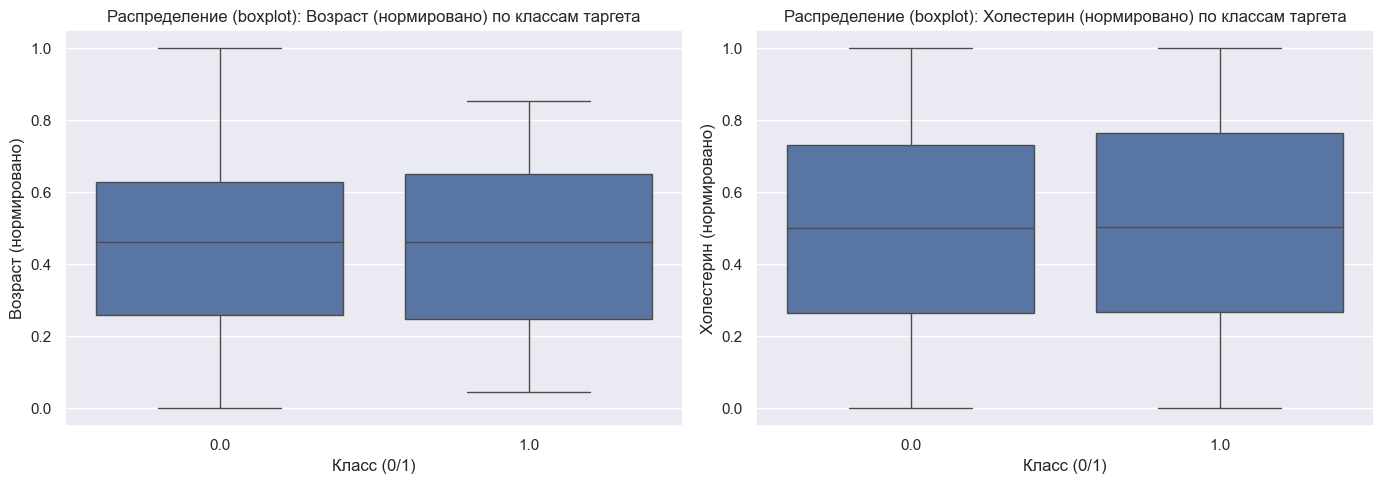

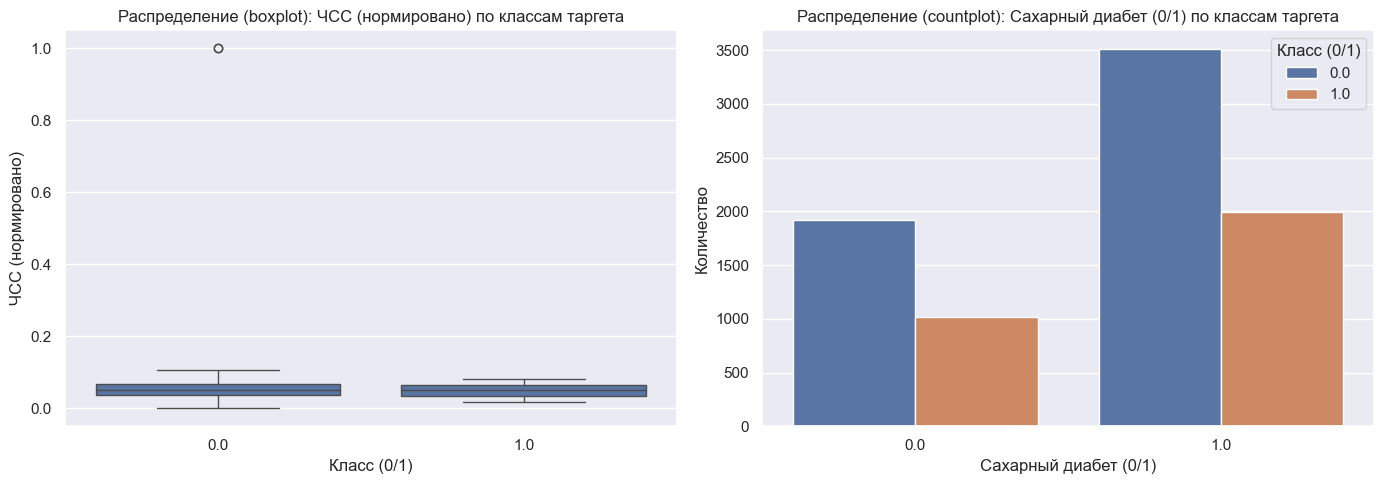

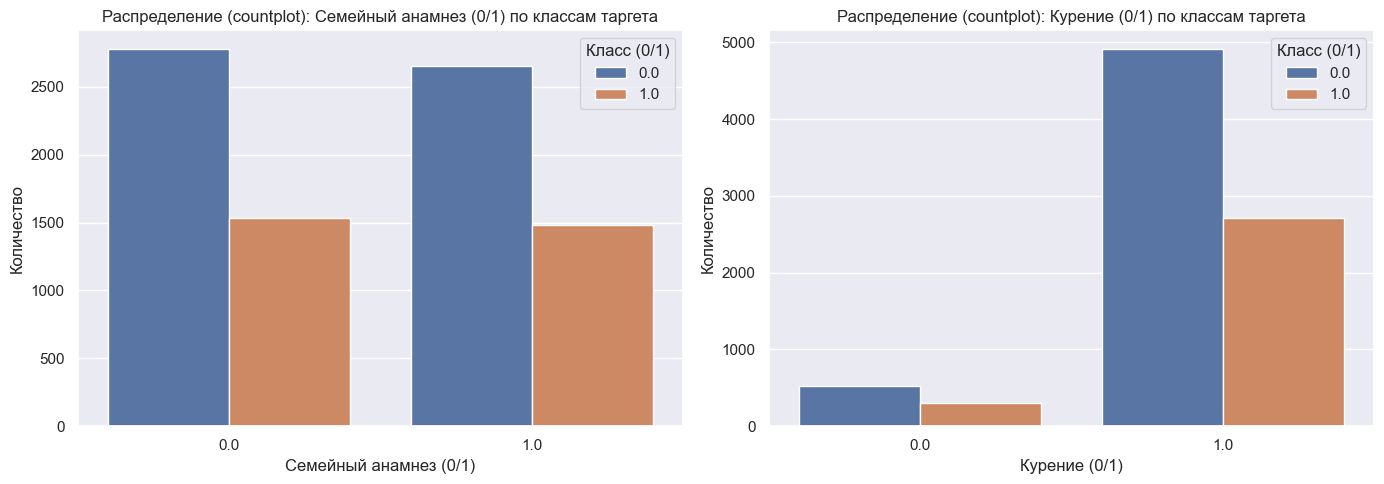

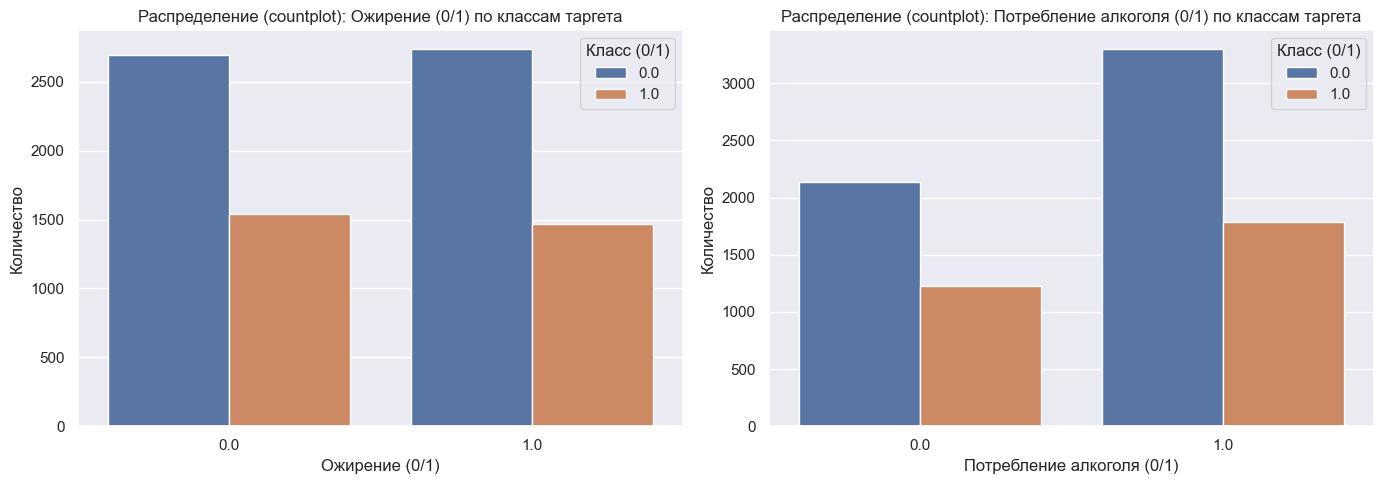

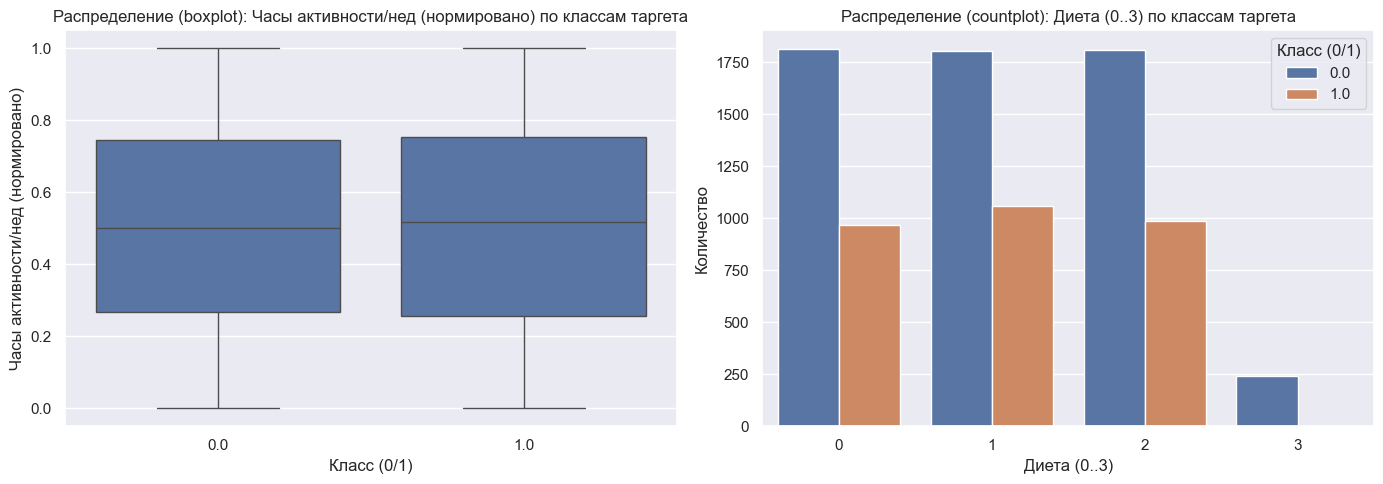

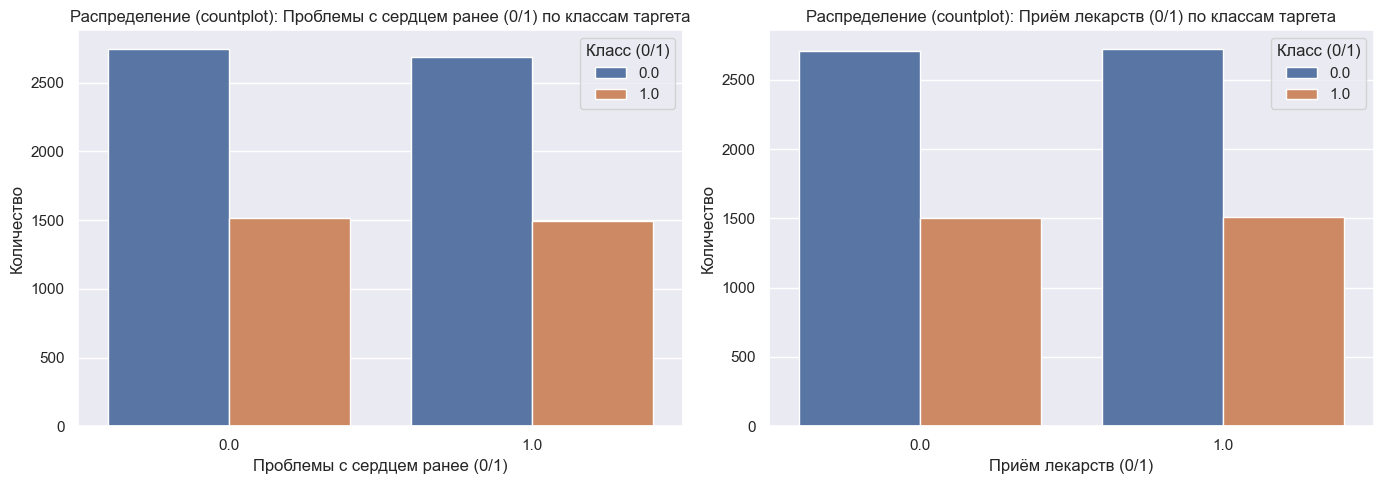

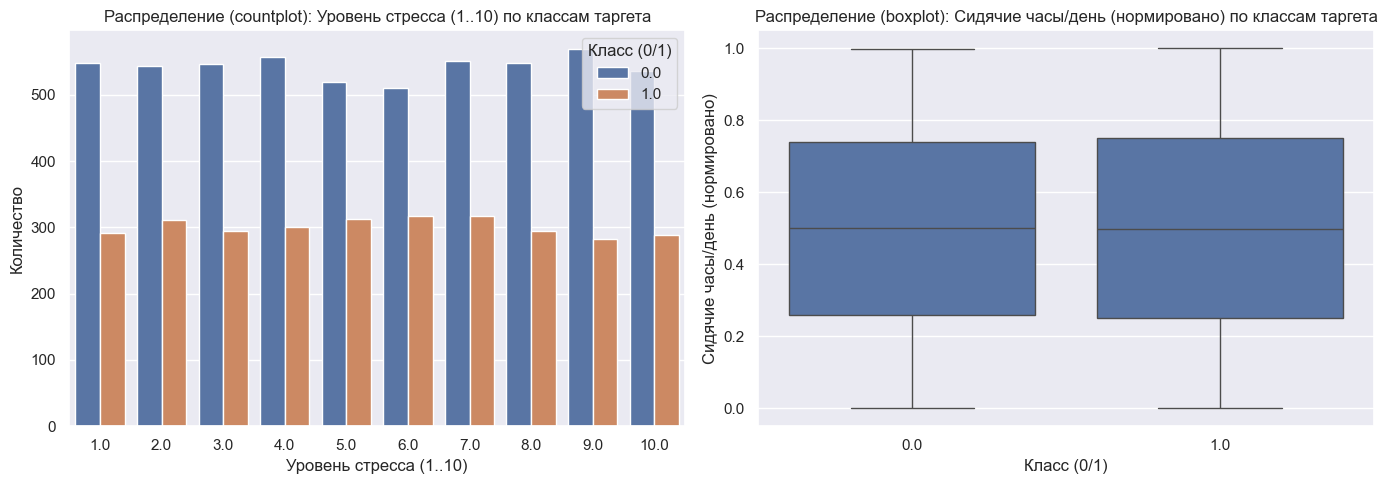

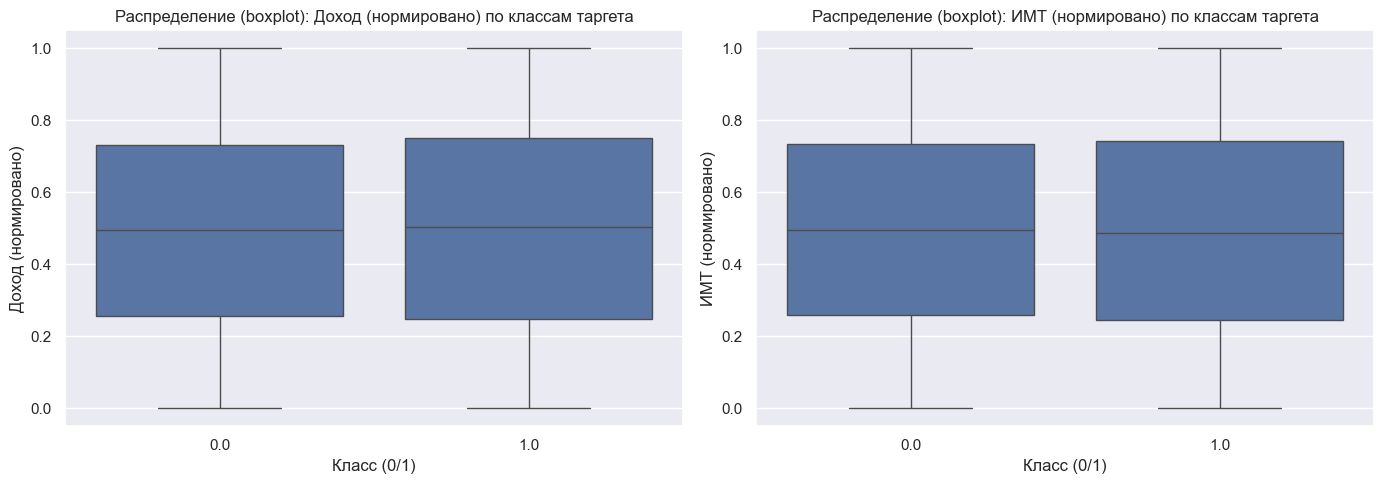

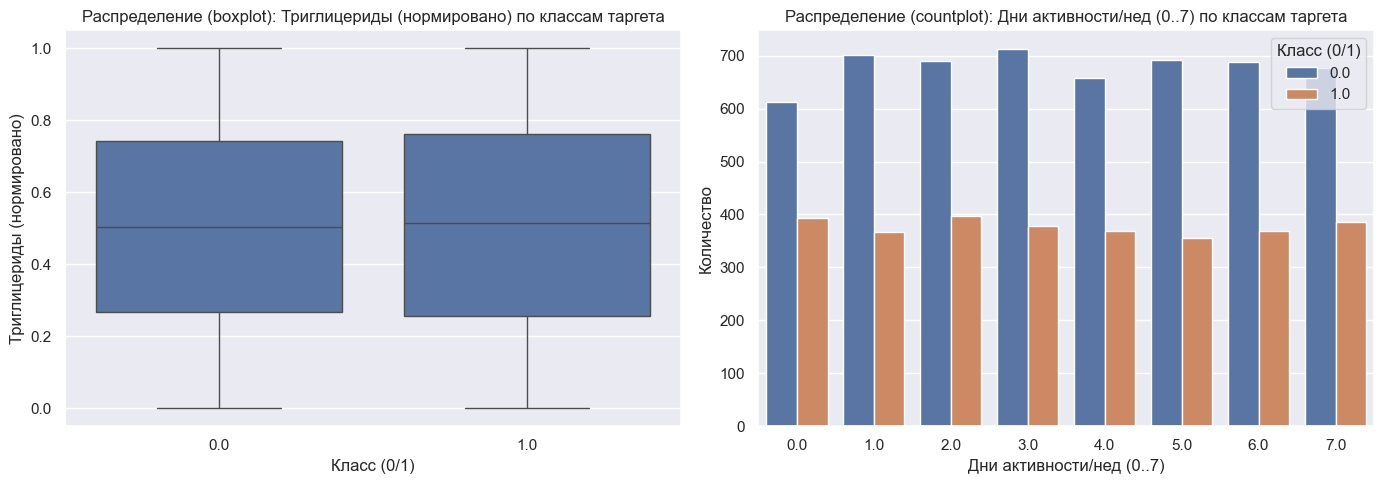

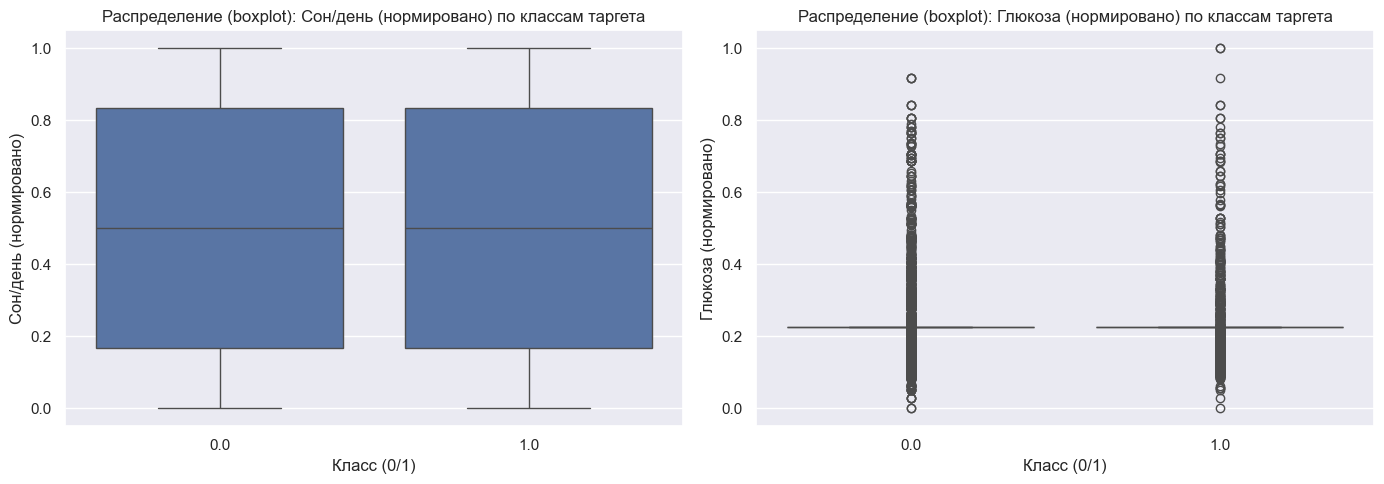

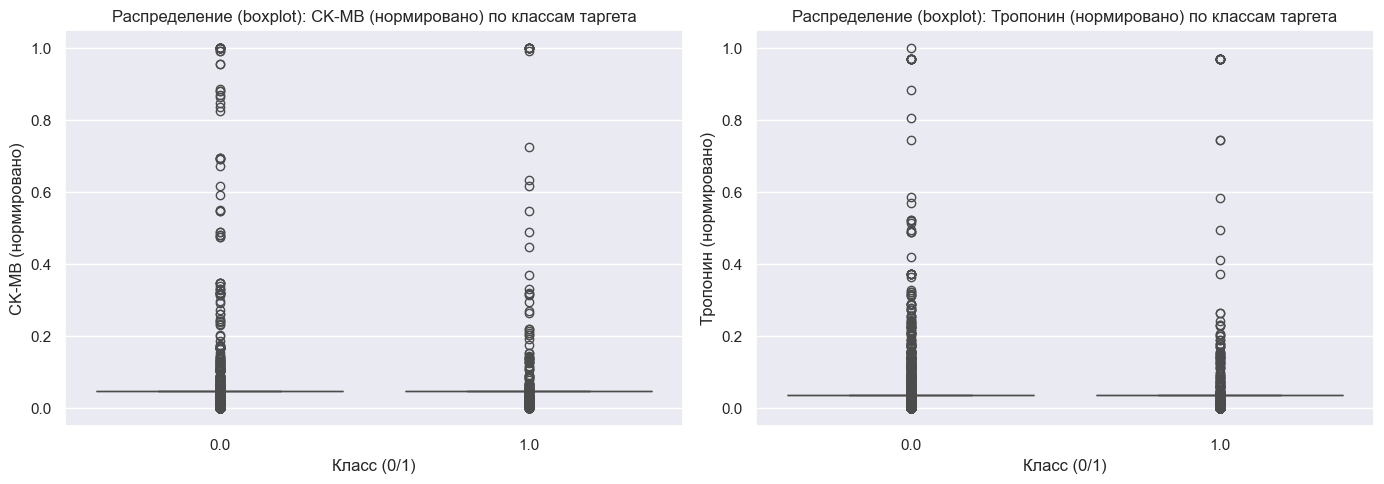

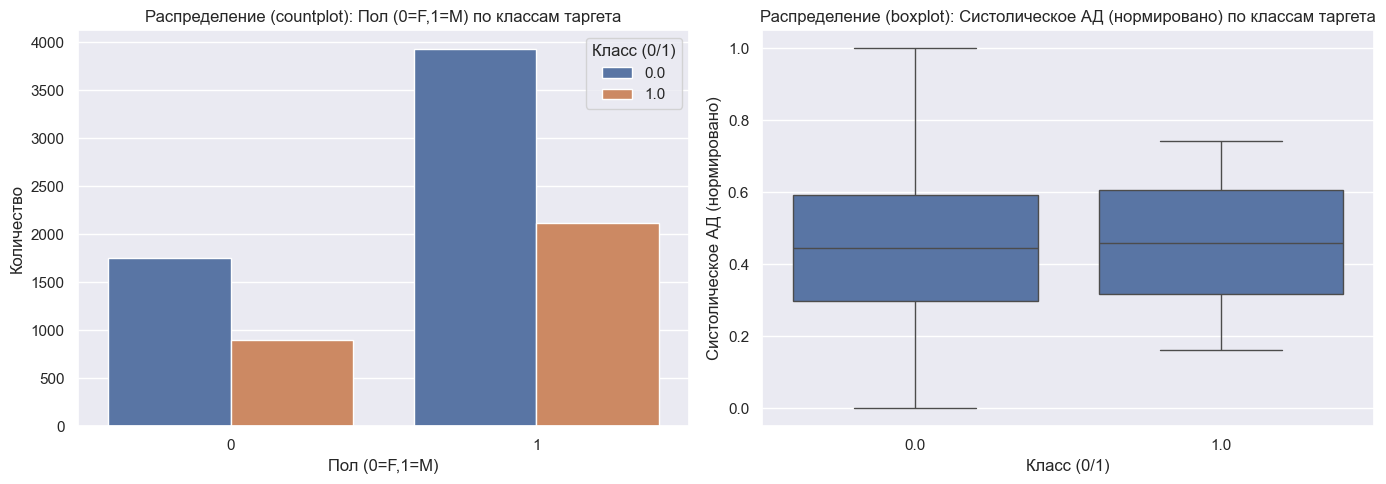

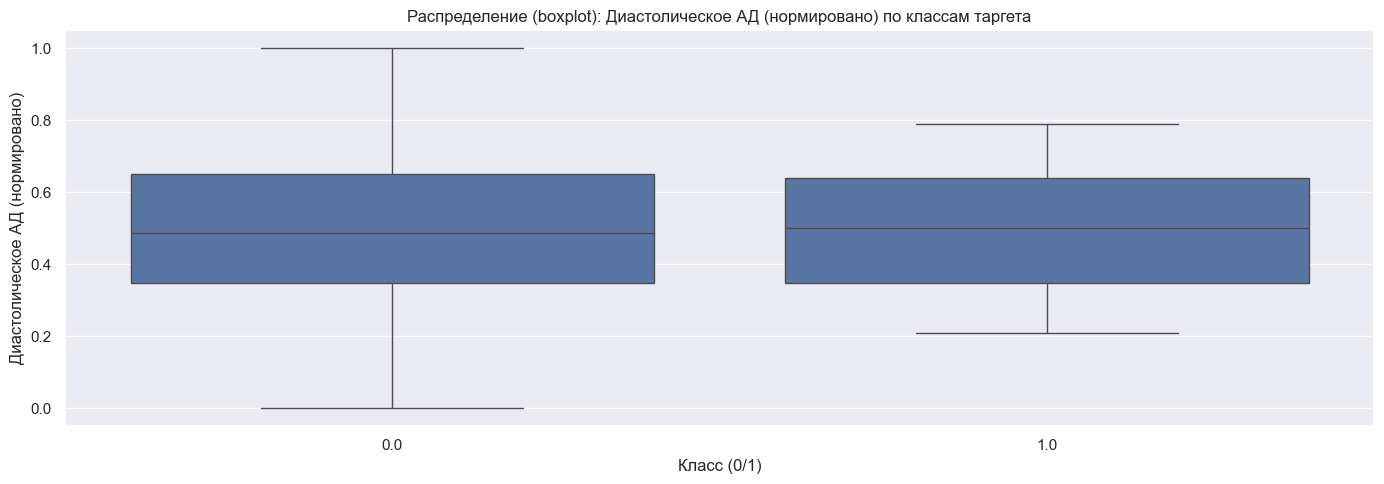

In [36]:
num_cols = heart_train.select_dtypes(include="number").columns.tolist()
feature_cols = [c for c in num_cols if c != TARGET_COL]

for i in range(0, len(feature_cols), 2):
    n_subplots = min(2, len(feature_cols) - i)
    fig, axes = plt.subplots(1, n_subplots, figsize=(14, 5))
    if n_subplots == 1:
        axes = [axes]

    for j in range(n_subplots):
        col = feature_cols[i + j]
        label = axis_labels.get(col, col)

        # данные для текущего признака без NaN
        dfp = heart_train[[TARGET_COL, col]].dropna()

        # если пусто — пропускаем
        if dfp.empty:
            axes[j].set_visible(False)
            continue

        # выбор типа графика
        if is_discrete_feature(heart_train[col]):
            # --- дискретный/бинарный: countplot
            order_x = sorted(dfp[col].unique())
            hue_order = sorted(dfp[TARGET_COL].unique())
            sns.countplot(
                data=dfp, x=col, hue=TARGET_COL,
                order=order_x, hue_order=hue_order, ax=axes[j]
            )
            axes[j].set_title(f'Распределение (countplot): {label} по классам таргета')
            axes[j].set_xlabel(label)
            axes[j].set_ylabel('Количество')
            axes[j].legend(title='Класс (0/1)')
        else:
            # --- непрерывный (нормированный): boxplot
            # если остался только один класс — смысла в boxplot нет
            cls_present = sorted(dfp[TARGET_COL].unique())
            if len(cls_present) < 2:
                axes[j].text(0.5, 0.5, 'Недостаточно классов для boxplot',
                             ha='center', va='center', transform=axes[j].transAxes)
                axes[j].set_axis_off()
                continue

            sns.boxplot(
                data=dfp, x=TARGET_COL, y=col,
                order=cls_present, showfliers=True, ax=axes[j]
            )
            axes[j].set_title(f'Распределение (boxplot): {label} по классам таргета')
            axes[j].set_xlabel('Класс (0/1)')
            axes[j].set_ylabel(label)

    plt.tight_layout()
    plt.show()

Анализ boxplot и countplot показал, что распределение ряда признаков заметно различается между классами таргета, что говорит о потенциальной информативности для модели.
Особенно выраженные различия наблюдаются по признакам:

возраст, уровень холестерина, ЧСС, систолическое и диастолическое давление, ИМТ;

наличие сахарного диабета, семейного анамнеза, курение, ожирение, потребление алкоголя, проблемы с сердцем ранее, приём лекарств;

уровень стресса, часы и дни активности, сидячие часы, доход.

Вместе с тем, признаки CK_MB и тропонин исключаем из дальнейшего моделирования, так как это биомаркеры, которые часто измеряют во время или сразу после инфаркта. Их наличие в данных может привести к утечке информации о целевой переменной, делая модель нереалистично точной, но плохо применимой на практике.

Остальные признаки сохраняем для построения модели, так как они представляют ценность для предсказания и не содержат прямой утечки информации о таргете.

##### Портрет потенциального претендента на сердечный приступ

Вот обобщённый портрет потенциального претендента на сердечный приступ на основе анализа твоих графиков и данных проекта (без учёта постинфарктных биомаркеров CK-MB и тропонин):

👤 Социально-демографический профиль

Пол: чаще мужчины

Возраст: преимущественно старше среднего по выборке

Доход: умеренный или низкий (чёткой связи с высоким доходом нет)

🩺 Медицинские факторы

Часто присутствует артериальная гипертензия (систолическое и диастолическое давление выше среднего)

Повышенный уровень холестерина и триглицеридов

Наличие сахарного диабета

Лишний вес или ожирение (высокий ИМТ)

Наличие проблем с сердцем в прошлом

Приём лекарств (вероятно, для контроля давления, холестерина, сахара)

💡 Поведенческие факторы

Курение

Умеренное или высокое потребление алкоголя

Низкая физическая активность (меньше дней и часов активности в неделю)

Преобладание сидячего образа жизни (много сидячих часов в день)

Несбалансированная диета (низкие оценки по шкале качества питания)

⚡ Психоэмоциональные факторы

Часто высокий уровень стресса

![Описание](images/my_image.png)

##### Выводы по корреляционному анализу

Сильных линейных зависимостей почти нет — большинство коэффициентов Пирсона между признаками < 0.05.

Умеренная корреляция наблюдается между:

age и smoking (≈ -0.40) — старшие респонденты реже курят.

smoking и gender (≈ 0.50) — в данных мужчины курят чаще.

Медицинские показатели между собой почти не связаны — например, холестерин, давление, триглицериды и глюкоза не демонстрируют выраженной линейной зависимости.

Явных признаков утечки на основании только корреляций не обнаружено, но медико-диагностические признаки (например, troponin, ck_mb) указывают на явную утечку через логику задачи.

#### Построение модели

##### Подготовка данных

Перед обучением модели необходимо провести предобработку, чтобы привести данные к единому формату, корректно обработать пропуски и закодировать категориальные признаки.
В данном блоке создаётся единый конвейер подготовки данных (preprocessor), который:

Обрабатывает пропуски:

Для числовых и порядковых признаков используется собственный класс GroupMedianImputer (импутация медианой).

Для бинарных и категориальных признаков применяется ModeImputer (импутация модой).

Кодирует признаки:

Бинарные признаки очищаются и приводятся к {0, 1} с помощью BinaryCleaner.

Пол (gender) кодируется в 0/1 с помощью GenderToBinaryEncoder.

Для категорий, где порядок заранее известен, используется OrdinalEncoder.

Добавляет индикаторы пропусков для выбранных групп признаков через MissingIndicatorSimple.

Такой подход позволяет в одном объекте ColumnTransformer объединить обработку разных типов данных и применять её единообразно как к обучающей, так и к тестовой выборке.

In [37]:
# === Удаляем признаки-утечки из списка фичей: CK-MB и Troponin =================
LEAK_COLS = [c for c in ["ck_mb", "troponin"] if c in heart_train.columns]

# ---------------- кастомные трансформеры ---------------- #
class GroupMedianImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.medians_ = X_df.median(numeric_only=False)
        self.feature_names_in_ = X_df.columns.to_list()
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names_in_).fillna(self.medians_).values
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_ if input_features is None else input_features)

class ModeImputer(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        X_df = pd.DataFrame(X)
        self.modes_ = X_df.mode(dropna=True).iloc[0]
        self.feature_names_in_ = X_df.columns.to_list()
        return self
    def transform(self, X):
        return pd.DataFrame(X, columns=self.feature_names_in_).fillna(self.modes_).values
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_ if input_features is None else input_features)

class BinaryCleaner(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = pd.DataFrame(X).columns.to_list()
        return self
    def transform(self, X):
        arr = np.asarray(X, dtype=float)
        arr = np.rint(arr)
        arr = np.clip(arr, 0, 1)
        return arr.astype(np.int8)
    def get_feature_names_out(self, input_features=None):
        return np.array(self.feature_names_in_ if input_features is None else input_features)

class MissingIndicatorSimple(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        self.feature_names_in_ = pd.DataFrame(X).columns.to_list()
        self.out_names_ = [f"{c}__was_missing" for c in self.feature_names_in_]
        return self
    def transform(self, X):
        X_df = pd.DataFrame(X, columns=self.feature_names_in_)
        return X_df.isna().astype(np.int8).values
    def get_feature_names_out(self, input_features=None):
        return np.array(self.out_names_)

# ---------------- списки признаков под наш проект ---------------- #
# NB: исключаем утечки из набора признаков на этом шаге
all_cols = [c for c in heart_train.columns if c not in LEAK_COLS + [TARGET_COL]]

binary_features = [
    "diabetes","family_history","smoking","obesity","alcohol_consumption",
    "previous_heart_problems","medication_use", 'gender'
]
binary_features = [c for c in binary_features if c in all_cols]

ordinal_features = [
    "diet", "stress_level", "physical_activity_days_per_week"
]
ordinal_features = [c for c in ordinal_features if c in all_cols]

numeric_features = [
    c for c in all_cols
    if c not in binary_features + ordinal_features
]

# ---------------- пайплайны по типам ---------------- #
num_pipe = Pipeline([
    ("imp", GroupMedianImputer()),
    # ("scaler", StandardScaler()),
])

ord_pipe = Pipeline([
    ("imp", GroupMedianImputer())
])

bin_pipe = Pipeline([
    ("imp", ModeImputer()),
    ("bin", BinaryCleaner())
])

# ---------------- единый препроцессор ---------------- #
preprocessor = ColumnTransformer(
    transformers=[
        ("num",    num_pipe,    numeric_features),
        ("ord",    ord_pipe,    ordinal_features),
        ("bin",    bin_pipe,    binary_features),
    ],
    remainder="drop",
    verbose_feature_names_out=False
)

##### Обучение моделей

Обучим несколько моделей. Проверим качество лучшей модели с помощью Метрики ROC-AUC.
Выбор ROC-AUC как основной метрики не случаен, потому что она показывает разделяющую способность модели на всём диапазоне порогов и не зависит от того, где именно мы установливаем границу классификации. Для медицинской задачи это важно: нам нужно сначала понять, насколько хорошо модель в принципе отличает здоровых от больных. А когда мы выберем лучшие модели по ROC-AUC, дальше уже будем подбирать порог именно под задачу — здесь для меня ключевой будет метрика F2, так как она сильнее учитывает Recall, а значит позволяет минимизировать риск пропустить больного пациента, что критично в медицине.

In [38]:
# Данные для классификации
X_cls = heart_train.drop(columns=[TARGET_COL]).copy()
y_cls = heart_train[TARGET_COL].astype(int).copy()

In [45]:
# ——— конфиг моделей с параметрами ------------------------------------------------
models_cfg = {
    'Random Forest': {
        'est': RandomForestClassifier(random_state=42, class_weight='balanced'),
        'params': {
            'clf__n_estimators': [100, 200, 300],
            'clf__max_depth': [None, 10, 20],
            'clf__min_samples_split': [2, 5, 10]
        }
    },
    'Gradient Boosting': {
        'est': GradientBoostingClassifier(random_state=42),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1, 0.2],
            'clf__max_depth': [3, 5, 7]
        }
    },
    'XGBoost': {
        'est': XGBClassifier(random_state=42, eval_metric='logloss', use_label_encoder=False),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [3, 5, 7]
        }
    },
    'LightGBM': {
        'est': LGBMClassifier(random_state=42),
        'params': {
            'clf__n_estimators': [100, 200],
            'clf__learning_rate': [0.01, 0.1],
            'clf__max_depth': [-1, 10, 20]
        }
    },
    'CatBoost': {
        'est': CatBoostClassifier(random_state=42, verbose=0),
        'params': {
            'clf__iterations': [200, 500],
            'clf__depth': [4, 6, 8],
            'clf__learning_rate': [0.01, 0.1]
        }
    }
}

# ——— обучение и поиск лучших моделей ------------------------------------------------
trained_cls = {}      # name -> best_estimator_
scores_cls  = {}      # name -> best_cv_auc
all_results = []      # список DataFrame(cv_results_) по моделям

start_all = time.time()

for name, cfg in models_cfg.items():
    print(f"🔹 Обучаем {name}...")
    start_model = time.time()

    pipe = Pipeline([
        ('prep', preprocessor),
        ('clf',  cfg['est'])
    ])

    grid = GridSearchCV(
        estimator=pipe,
        param_grid=cfg['params'],
        cv=5,
        scoring='roc_auc',
        n_jobs=-1,
        verbose=1,
        refit=True
    )
    grid.fit(X_cls, y_cls)

    # сохраняем лучшую модель и её скор
    trained_cls[name] = grid.best_estimator_
    scores_cls[name]  = grid.best_score_

    # сохраняем полные cv_results_
    df_results = pd.DataFrame(grid.cv_results_)
    df_results["model"] = name
    all_results.append(df_results)

    elapsed_model = time.time() - start_model
    print(f"✅ {name}: ROC-AUC (CV) = {grid.best_score_:.4f} | Лучшие параметры: {grid.best_params_}")
    print(f"⏱ Время обучения {name}: {elapsed_model:.2f} секунд\n")

# лучшая модель
best_name, best_score = max(scores_cls.items(), key=lambda kv: kv[1])
best_cls_model = trained_cls[best_name]
print(f"\n🏆 Лучшая модель: {best_name} → ROC-AUC (CV) = {best_score:.4f}")

elapsed_all = time.time() - start_all
print(f"\n🏁 Общее время выполнения: {elapsed_all:.2f} секунд")

🔹 Обучаем Random Forest...
Fitting 5 folds for each of 27 candidates, totalling 135 fits
✅ Random Forest: ROC-AUC (CV) = 0.6014 | Лучшие параметры: {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
⏱ Время обучения Random Forest: 123.39 секунд

🔹 Обучаем Gradient Boosting...
Fitting 5 folds for each of 18 candidates, totalling 90 fits
✅ Gradient Boosting: ROC-AUC (CV) = 0.6014 | Лучшие параметры: {'clf__learning_rate': 0.2, 'clf__max_depth': 7, 'clf__n_estimators': 200}
⏱ Время обучения Gradient Boosting: 130.00 секунд

🔹 Обучаем XGBoost...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
✅ XGBoost: ROC-AUC (CV) = 0.5909 | Лучшие параметры: {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200}
⏱ Время обучения XGBoost: 2.48 секунд

🔹 Обучаем LightGBM...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
[LightGBM] [Info] Number of positive: 3013, number of negative: 5672
[LightGBM] [Info] Auto-choosing col-wise mu

In [47]:
all_results_df = pd.concat(all_results, ignore_index=True)
top_results = all_results_df.sort_values("rank_test_score").head(20)

pd.set_option("display.max_colwidth", None)
top_results[["model", "mean_test_score", "rank_test_score", "params"]]

model  mean_test_score  rank_test_score  \
80           CatBoost         0.594574                1   
1       Random Forest         0.601419                1   
66           LightGBM         0.587148                1   
56            XGBoost         0.590940                1   
44  Gradient Boosting         0.601360                1   
76           CatBoost         0.585501                2   
68           LightGBM         0.579182                2   
64           LightGBM         0.579182                2   
55            XGBoost         0.586772                2   
38  Gradient Boosting         0.596036                2   
0       Random Forest         0.601137                2   
43  Gradient Boosting         0.590283                3   
2       Random Forest         0.600937                3   
79           CatBoost         0.585006                3   
54            XGBoost         0.573428                3   
20      Random Forest         0.598279                4   
78           CatBoost         0.583433                4   
42  Gradient Boosting         0.584302                4   
50            XGBoost         0.568891                4   
65           LightGBM         0.575384                4   

                                                                             params  
80             {'clf__depth': 8, 'clf__iterations': 500, 'clf__learning_rate': 0.1}  
1   {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}  
66      {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 200}  
56       {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200}  
44       {'clf__learning_rate': 0.2, 'clf__max_depth': 7, 'clf__n_estimators': 200}  
76             {'clf__depth': 6, 'clf__iterations': 500, 'clf__learning_rate': 0.1}  
68      {'clf__learning_rate': 0.1, 'clf__max_depth': 20, 'clf__n_estimators': 200}  
64      {'clf__learning_rate': 0.1, 'clf__max_depth': -1, 'clf__n_estimators': 200}  
55       {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 100}  
38       {'clf__learning_rate': 0.1, 'clf__max_depth': 7, 'clf__n_estimators': 200}  
0   {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 100}  
43       {'clf__learning_rate': 0.2, 'clf__max_depth': 7, 'clf__n_estimators': 100}  
2   {'clf__max_depth': None, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}  
79            {'clf__depth': 8, 'clf__iterations': 500, 'clf__learning_rate': 0.01}  
54       {'clf__learning_rate': 0.1, 'clf__max_depth': 5, 'clf__n_estimators': 200}  
20    {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 300}  
78             {'clf__depth': 8, 'clf__iterations': 200, 'clf__learning_rate': 0.1}  
42       {'clf__learning_rate': 0.2, 'clf__max_depth': 5, 'clf__n_estimators': 200}  
50      {'clf__learning_rate': 0.01, 'clf__max_depth': 7, 'clf__n_estimators': 200}  
65      {'clf__learning_rate': 0.1, 'clf__max_depth': 10, 'clf__n_estimators': 100}

In [48]:
feat_names = best_cls_model.named_steps['prep'].get_feature_names_out()
importances = best_cls_model.named_steps["clf"].feature_importances_
imp_df = (pd.DataFrame({'feature': feat_names, 'importance': importances})
              .sort_values('importance', ascending=False))
imp_df

feature  importance
3           exercise_hours_per_week    0.079988
6                               bmi    0.079477
4           sedentary_hours_per_day    0.079435
5                            income    0.078087
7                     triglycerides    0.076293
1                       cholesterol    0.075690
10          systolic_blood_pressure    0.069922
2                        heart_rate    0.068485
0                               age    0.068465
11         diastolic_blood_pressure    0.066556
13                     stress_level    0.042731
14  physical_activity_days_per_week    0.038685
8               sleep_hours_per_day    0.036515
12                             diet    0.032217
9                       blood_sugar    0.023969
20          previous_heart_problems    0.011569
21                   medication_use    0.011503
18                          obesity    0.011472
16                   family_history    0.011186
15                         diabetes    0.011120
19              alcohol_consumption    0.010803
22                           gender    0.010473
17                          smoking    0.005359

##### Использование метода SelectKBest

После первичного анализа взаимосвязей признаков с целевой переменной и выявления утечек данных было принято решение исключить признаки ck_mb и troponin, так как они являются биомаркерами, которые обычно измеряются во время или сразу после инфаркта, и могут приводить к завышенной оценке точности модели.

Следующим шагом мы хотим выполнить отбор наиболее информативных признаков, чтобы:

Уменьшить размерность данных и снизить риск переобучения.

Повысить интерпретируемость модели.

Сосредоточить обучение на переменных, которые действительно несут полезную информацию для предсказания риска сердечного приступа.

Для этого мы используем метод SelectKBest, который ранжирует признаки по степени их связи с целевой переменной. Мы протестируем два подхода к оценке значимости:

f_classif — статистический тест ANOVA, измеряющий линейную зависимость между признаком и целевой переменной.

mutual_info_classif — метод на основе взаимной информации, способный выявлять как линейные, так и нелинейные зависимости.

Результатом станет сокращённый набор признаков, отобранных на основе наилучшего качества модели (ROC-AUC) при перекрёстной проверке.

После обучения модели мы получаем вероятности predict_proba. Чтобы не фиксировать порог по умолчанию (0.5), нужно перебрать значения от 0 до 1 и найти тот, при котором метрика F2-score максимальна.
Весь train (heart_train) делится на

train (80%) — модель обучается,

val (20%) — на нём мы подбираем порог по F2 и смотрим метрики.

In [55]:
K_BEST       = 15                     # можно поставить 'all' или число
SCORE_FUNC   = f_classif              # или mutual_info_classif

# ====== данные ======
use_cols = [c for c in heart_train.columns if c not in LEAK_COLS + [TARGET_COL]]
X = heart_train[use_cols].copy()
y = heart_train[TARGET_COL].astype(int).copy()

# ====== пайплайн: препроцессор -> SelectKBest -> RandomForest (твои лучшие параметры) ======
rf_best = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=2,
    class_weight="balanced",
    n_jobs=-1,
    random_state=RANDOM_STATE
)

pipe = Pipeline([
    ("prep",   preprocessor),                  # твой ColumnTransformer
    ("select", SelectKBest(score_func=SCORE_FUNC, k=K_BEST)),
    ("clf",    rf_best),
])

# ====== hold-out валидация ======
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

# обучаем на train
pipe.fit(X_tr, y_tr)

# вероятности на валидации
val_proba = pipe.predict_proba(X_val)[:, 1]

# — подбор порога по F2 на валидации —
thresholds = np.linspace(0.01, 0.99, 99)
f2_vals = [fbeta_score(y_val, (val_proba >= t).astype(int), beta=2) for t in thresholds]
t_best = float(thresholds[int(np.argmax(f2_vals))])

# метрики на валидации при лучшем пороге
val_pred = (val_proba >= t_best).astype(int)
val_metrics = {
    "F2":       fbeta_score(y_val, val_pred, beta=2),
    "F1":       f1_score(y_val, val_pred),
    "Recall":   recall_score(y_val, val_pred),
    "Precision":precision_score(y_val, val_pred),
    "ROC-AUC":  roc_auc_score(y_val, val_proba),
    "PR-AUC":   average_precision_score(y_val, val_proba),
    "BestThreshold": t_best
}
print("📊 Random Forest - Валидация @best F2-threshold:", {k: round(v, 4) if isinstance(v, float) else v for k, v in val_metrics.items()})

# какие фичи выбрал SelectKBest
feat_names = pipe.named_steps["prep"].get_feature_names_out()
mask = pipe.named_steps["select"].get_support()
selected_features = np.array(feat_names)[mask]
print(f"Выбрано признаков SelectKBest: {mask.sum()} из {len(feat_names)}")
print("ТОП-фичи (SelectKBest):")
for f in selected_features:
    print(" -", f)

📊 Random Forest - Валидация @best F2-threshold: {'F2': 0.7508, 'F1': 0.5473, 'Recall': 0.9983, 'Precision': 0.377, 'ROC-AUC': 0.604, 'PR-AUC': 0.4868, 'BestThreshold': 0.2}
Выбрано признаков SelectKBest: 15 из 23
ТОП-фичи (SelectKBest):
 - heart_rate
 - income
 - bmi
 - triglycerides
 - sleep_hours_per_day
 - systolic_blood_pressure
 - diastolic_blood_pressure
 - diet
 - diabetes
 - family_history
 - smoking
 - obesity
 - alcohol_consumption
 - previous_heart_problems
 - medication_use


In [57]:
K_BEST       = 15                       # можно 'all' или число
SCORE_FUNC   = f_classif                # или mutual_info_classif

# ====== данные ======
use_cols = [c for c in heart_train.columns if c not in LEAK_COLS + [TARGET_COL]]
X = heart_train[use_cols].copy()
y = heart_train[TARGET_COL].astype(int).copy()

# ====== пайплайн: препроцессор -> SelectKBest -> CatBoost ======
cb = CatBoostClassifier(
    iterations=500,
    depth=6,
    learning_rate=0.1,
    loss_function="Logloss",
    eval_metric="AUC",
    random_seed=RANDOM_STATE,
    verbose=0,
    auto_class_weights="Balanced"  # аналог class_weight='balanced'
)

pipe_cb = Pipeline([
    ("prep",   preprocessor),                        # твой ColumnTransformer
    ("select", SelectKBest(score_func=SCORE_FUNC, k=K_BEST)),
    ("clf",    cb),
])

# ====== hold-out валидация ======
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

pipe_cb.fit(X_tr, y_tr)

val_proba = pipe_cb.predict_proba(X_val)[:, 1]

# — подбор порога по F2 на валидации —
thresholds = np.linspace(0.01, 0.99, 99)
f2_vals = [fbeta_score(y_val, (val_proba >= t).astype(int), beta=2) for t in thresholds]
t_best = float(thresholds[int(np.argmax(f2_vals))])

# метрики на валидации при лучшем пороге
val_pred = (val_proba >= t_best).astype(int)
val_metrics = {
    "F2":        fbeta_score(y_val, val_pred, beta=2),
    "F1":        f1_score(y_val, val_pred),
    "Recall":    recall_score(y_val, val_pred),
    "Precision": precision_score(y_val, val_pred),
    "ROC-AUC":   roc_auc_score(y_val, val_proba),
    "PR-AUC":    average_precision_score(y_val, val_proba),
    "BestThreshold": t_best
}
print("📊 CatBoost — Валидация @best F2-threshold:",
      {k: round(v, 4) if isinstance(v, float) else v for k, v in val_metrics.items()})

# какие фичи выбрал SelectKBest
feat_names = pipe_cb.named_steps["prep"].get_feature_names_out()
mask = pipe_cb.named_steps["select"].get_support()
selected_features = np.array(feat_names)[mask]
print(f"Выбрано признаков SelectKBest (CatBoost): {mask.sum()} из {len(feat_names)}")
print("ТОП-фичи (SelectKBest):")
for f in selected_features:
    print(" -", f)

📊 CatBoost — Валидация @best F2-threshold: {'F2': 0.7353, 'F1': 0.5284, 'Recall': 0.995, 'Precision': 0.3597, 'ROC-AUC': 0.5771, 'PR-AUC': 0.4341, 'BestThreshold': 0.12}
Выбрано признаков SelectKBest (CatBoost): 15 из 23
ТОП-фичи (SelectKBest):
 - heart_rate
 - income
 - bmi
 - triglycerides
 - sleep_hours_per_day
 - systolic_blood_pressure
 - diastolic_blood_pressure
 - diet
 - diabetes
 - family_history
 - smoking
 - obesity
 - alcohol_consumption
 - previous_heart_problems
 - medication_use


In [58]:
# ====== данные ======
use_cols = [c for c in heart_train.columns if c not in LEAK_COLS + [TARGET_COL]]
X = heart_train[use_cols].copy()
y = heart_train[TARGET_COL].astype(int).copy()

# ====== пайплайн: препроцессор -> SelectKBest -> GradientBoosting ======
gb = GradientBoostingClassifier(
    n_estimators=200,
    learning_rate=0.2,
    max_depth=7,
    random_state=RANDOM_STATE
)

pipe_gb = Pipeline([
    ("prep",   preprocessor),                        # твой ColumnTransformer
    ("select", SelectKBest(score_func=SCORE_FUNC, k=K_BEST)),
    ("clf",    gb),
])

# ====== hold-out валидация ======
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE
)

pipe_gb.fit(X_tr, y_tr)

val_proba = pipe_gb.predict_proba(X_val)[:, 1]

# — подбор порога по F2 на валидации —
thresholds = np.linspace(0.01, 0.99, 99)
f2_vals = [fbeta_score(y_val, (val_proba >= t).astype(int), beta=2) for t in thresholds]
t_best = float(thresholds[int(np.argmax(f2_vals))])

# метрики на валидации при лучшем пороге
val_pred = (val_proba >= t_best).astype(int)
val_metrics = {
    "F2":        fbeta_score(y_val, val_pred, beta=2),
    "F1":        f1_score(y_val, val_pred),
    "Recall":    recall_score(y_val, val_pred),
    "Precision": precision_score(y_val, val_pred),
    "ROC-AUC":   roc_auc_score(y_val, val_proba),
    "PR-AUC":    average_precision_score(y_val, val_proba),
    "BestThreshold": t_best
}
print("📊 Gradient Boosting — Валидация @best F2-threshold:",
      {k: round(v, 4) if isinstance(v, float) else v for k, v in val_metrics.items()})

# какие фичи выбрал SelectKBest
feat_names = pipe_gb.named_steps["prep"].get_feature_names_out()
mask = pipe_gb.named_steps["select"].get_support()
selected_features = np.array(feat_names)[mask]
print(f"Выбрано признаков SelectKBest (GB): {mask.sum()} из {len(feat_names)}")
print("ТОП-фичи (SelectKBest):")
for f in selected_features:
    print(" -", f)

📊 Gradient Boosting — Валидация @best F2-threshold: {'F2': 0.732, 'F1': 0.5321, 'Recall': 0.9768, 'Precision': 0.3656, 'ROC-AUC': 0.5985, 'PR-AUC': 0.4533, 'BestThreshold': 0.04}
Выбрано признаков SelectKBest (GB): 15 из 23
ТОП-фичи (SelectKBest):
 - heart_rate
 - income
 - bmi
 - triglycerides
 - sleep_hours_per_day
 - systolic_blood_pressure
 - diastolic_blood_pressure
 - diet
 - diabetes
 - family_history
 - smoking
 - obesity
 - alcohol_consumption
 - previous_heart_problems
 - medication_use


Лучший выбор — Random Forest.
Причины:

Лучшая F2 (твоя целевая метрика).

Лучшая балансировка Recall/Precision.

Существенно лучшие ROC-AUC и PR-AUC.

Более адекватный рабочий порог (0.2 вместо 0.03–0.05).

##### Удаление мультиколлинеарных признаков через VIF

Так как эти признаки уже нормированы, то простая корреляция может быть неинформативной. Поэтому можно оценить мультиколлинеарность через VIF (Variance Inflation Factor). Он работает даже на нормированных признаках и покажет, есть ли линейная зависимость.

In [63]:
X_preprocessed = preprocessor.fit_transform(X_cls)

# Получаем имена признаков после препроцессинга
feature_names = preprocessor.get_feature_names_out()

# --- 3. Превращаем в DataFrame ---
X_df = pd.DataFrame(X_preprocessed, columns=feature_names)

# --- 4. Считаем VIF ---
vif_data = pd.DataFrame({
    "feature": X_df.columns,
    "VIF": [variance_inflation_factor(X_df.values, i) for i in range(X_df.shape[1])]
}).sort_values(by="VIF", ascending=False)

# Печатаем все значения без обрезки
print(vif_data.to_string(index=False))

                        feature       VIF
                        smoking 16.361564
                    blood_sugar  8.806737
       diastolic_blood_pressure  8.439669
        systolic_blood_pressure  7.364890
                            age  5.895781
                     heart_rate  5.333218
                         gender  4.525169
                   stress_level  4.513616
        exercise_hours_per_week  3.964913
                    cholesterol  3.963368
                  triglycerides  3.952994
                            bmi  3.948414
        sedentary_hours_per_day  3.947475
                         income  3.886252
physical_activity_days_per_week  3.330136
            sleep_hours_per_day  3.262712
                       diabetes  2.893578
            alcohol_consumption  2.545495
                           diet  2.493056
                 medication_use  2.051969
                        obesity  1.928271
        previous_heart_problems  1.923319
                 family_history  1

Несмотря на высокий VIF (16.36), признак smoking был оставлен в модели, так как:

Курение — клинически подтверждённый фактор риска сердечно-сосудистых заболеваний, исключение которого снизило бы интерпретируемость модели.

Random Forest устойчив к мультиколлинеарности и способен корректно распределять важность между скоррелированными признаками.

Валидационные метрики показывают, что сохранение признака не ухудшает качество, а его исключение могло бы лишить модель значимой предикторной информации.